In [15]:
library(FNN)
library(dplyr)
library(nnet)
library(ggplot2)
library(reshape2)
library(purrr)
library(tidyr)
library(ggplot2)
library(glmnet)
library(tree)
library(Epi)
library(party)
library(pROC)
library(ROCR)
library(tree)
library(ROCR)
library(ggplot2)
library(foreign)
library(rpart)
library(rpart.plot)
library(rattle)
library(h2o)
h2o.init(nthreads = 4)
library(fastAdaboost)
library(mlbench)
library(caret)
library(caretEnsemble)
library(adabag)

#install.packages("solitude")
library(solitude)

#install.packages("caret")
#install.packages("doParallel")

library(caret)
library(doParallel)

#install.packages("randomForest")
library(randomForest)

#install.packages("gbm")
library(gbm)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 days 53 minutes 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.3 
    H2O cluster version age:    13 days  
    H2O cluster name:           H2O_started_from_R_user_fgh541 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.55 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.4 (2021-02-15) 



In [16]:
#test<-read.csv("C:/Users/user/PycharmProjects/4_1_multivariate analysis/test_values.csv")
train_y<-read.csv("C:/Users/user/PycharmProjects/4_1_multivariate analysis/train_labels.csv")
train<-read.csv("C:/Users/user/PycharmProjects/4_1_multivariate analysis/train_values.csv")


In [17]:
str(train)

'data.frame':	260601 obs. of  39 variables:
 $ building_id                           : int  802906 28830 94947 590882 201944 333020 728451 475515 441126 989500 ...
 $ geo_level_1_id                        : int  6 8 21 22 11 8 9 20 0 26 ...
 $ geo_level_2_id                        : int  487 900 363 418 131 558 475 323 757 886 ...
 $ geo_level_3_id                        : int  12198 2812 8973 10694 1488 6089 12066 12236 7219 994 ...
 $ count_floors_pre_eq                   : int  2 2 2 2 3 2 2 2 2 1 ...
 $ age                                   : int  30 10 10 10 30 10 25 0 15 0 ...
 $ area_percentage                       : int  6 8 5 6 8 9 3 8 8 13 ...
 $ height_percentage                     : int  5 7 5 5 9 5 4 6 6 4 ...
 $ land_surface_condition                : chr  "t" "o" "t" "t" ...
 $ foundation_type                       : chr  "r" "r" "r" "r" ...
 $ roof_type                             : chr  "n" "n" "n" "n" ...
 $ ground_floor_type                     : chr  "f" "x" "f" "

In [18]:
train_y$damage_grade<-as.factor(train_y$damage_grade)

# 사전 작업 사항

1. numeric 아닌거 찾고 factor로 변환한 뒤, 원핫 인코딩으로 만들기
    `class.ind()` 
2. 150,000 개의 빌딩이 포함된 Training dataset 과 50,000 개의 Validation dataset, 그리고 60,601 개의 Test dataset으로 나눠줌

In [19]:
# numeric변수만 찾기
data_num2<-train %>% keep(is.numeric)
# numeric 변수 제외하고  뽑기
data_not_num = train[, !(names(train)) %in% colnames(data_num2)]

In [20]:
str(data_not_num)

'data.frame':	260601 obs. of  8 variables:
 $ land_surface_condition: chr  "t" "o" "t" "t" ...
 $ foundation_type       : chr  "r" "r" "r" "r" ...
 $ roof_type             : chr  "n" "n" "n" "n" ...
 $ ground_floor_type     : chr  "f" "x" "f" "f" ...
 $ other_floor_type      : chr  "q" "q" "x" "x" ...
 $ position              : chr  "t" "s" "t" "s" ...
 $ plan_configuration    : chr  "d" "d" "d" "d" ...
 $ legal_ownership_status: chr  "v" "v" "v" "v" ...


In [21]:
data_char <- data_not_num %>% mutate_if(is.character,as.factor)
str(data_char)

'data.frame':	260601 obs. of  8 variables:
 $ land_surface_condition: Factor w/ 3 levels "n","o","t": 3 2 3 3 3 3 1 3 3 3 ...
 $ foundation_type       : Factor w/ 5 levels "h","i","r","u",..: 3 3 3 3 3 3 3 5 3 2 ...
 $ roof_type             : Factor w/ 3 levels "n","q","x": 1 1 1 1 1 1 1 2 2 1 ...
 $ ground_floor_type     : Factor w/ 5 levels "f","m","v","x",..: 1 4 1 1 1 1 4 3 1 3 ...
 $ other_floor_type      : Factor w/ 4 levels "j","q","s","x": 2 2 4 4 4 2 2 4 2 1 ...
 $ position              : Factor w/ 4 levels "j","o","s","t": 4 3 4 3 3 3 3 3 3 3 ...
 $ plan_configuration    : Factor w/ 10 levels "a","c","d","f",..: 3 3 3 3 3 3 3 10 3 3 ...
 $ legal_ownership_status: Factor w/ 4 levels "a","r","v","w": 3 3 3 3 3 3 3 3 3 3 ...


In [22]:
#data_fac2 : character to numeric
dummy1 <- class.ind(data_char[,1])[,-1]
colnames(dummy1) <- paste(rep(colnames(data_char)[1],ncol(dummy1)),colnames(dummy1),sep="_")

dummy2 <- class.ind(data_char[,2])[,-1]
colnames(dummy2) <- paste(rep(colnames(data_char)[2],ncol(dummy2)),colnames(dummy2),sep="_")

dummy3 <- class.ind(data_char[,3])[,-1]
colnames(dummy3) <- paste(rep(colnames(data_char)[3],ncol(dummy3)),colnames(dummy3),sep="_")

dummy4 <- class.ind(data_char[,4])[,-1]
colnames(dummy4) <- paste(rep(colnames(data_char)[4],ncol(dummy4)),colnames(dummy4),sep="_")

dummy5 <- class.ind(data_char[,5])[,-1]
colnames(dummy5) <- paste(rep(colnames(data_char)[5],ncol(dummy5)),colnames(dummy5),sep="_")

dummy6 <- class.ind(data_char[,6])[,-1]
colnames(dummy6) <- paste(rep(colnames(data_char)[6],ncol(dummy6)),colnames(dummy6),sep="_")

dummy7 <- class.ind(data_char[,7])[,-1]
colnames(dummy7) <- paste(rep(colnames(data_char)[7],ncol(dummy7)),colnames(dummy7),sep="_")

dummy8 <- class.ind(data_char[,8])[,-1]
colnames(dummy8) <- paste(rep(colnames(data_char)[8],ncol(dummy8)),colnames(dummy8),sep="_")

dummys <- cbind(dummy1, dummy2, dummy3, dummy4, dummy5, dummy6, dummy7, dummy8)
data<-cbind(data_num2,dummys)

## data for ann

In [23]:
# df2 : normalized data set : ann을 만들기 위해 scale했습니다

data_<-scale(data_num2[,-1], center = TRUE, scale = TRUE)
df_<-cbind(data_num2$building_id, data_, dummys)
colnames(df_)[1]<-"building_id"
df2 <- merge(df_,train_y)

# merge용 컬럼과 의변변수 지우기
ann_x <- df2[,-c(1,62)]
# ann을 위해서 y변수도 원핫인코딩 실행
ann_y <- class.ind(df2[,62])


In [24]:
trn_idx <- c(1:50000)
val_idx<-c(50001:110602)
tst_idx<-c(110603:260601 )

trn_data_x <- ann_x[trn_idx,]
val_data_x <- ann_x[val_idx,]
tst_data_x <- ann_x[tst_idx,]

trn_data_y <- ann_y[trn_idx,]
val_data_y <- ann_y[val_idx,]
tst_data_y <- ann_y[tst_idx,]

## decision tree 를 위한 data형
원 핫 인코딩 안한 데이터를 사용했습니다

In [25]:
data_1 <- cbind(data_num2,data_char)
data_dt <- merge(data_1,train_y)
data_dt <- data_dt[,-1]
str(data_dt)

'data.frame':	260601 obs. of  39 variables:
 $ geo_level_1_id                        : int  30 17 17 4 3 26 8 6 7 20 ...
 $ geo_level_2_id                        : int  266 409 716 651 1387 1132 1297 398 555 508 ...
 $ geo_level_3_id                        : int  1224 12182 7056 105 3909 6645 9721 4512 2763 10459 ...
 $ count_floors_pre_eq                   : int  1 2 2 2 5 2 2 2 3 2 ...
 $ age                                   : int  25 0 5 80 40 0 0 30 40 5 ...
 $ area_percentage                       : int  5 13 12 5 5 6 2 10 5 7 ...
 $ height_percentage                     : int  2 7 6 4 10 6 6 5 6 6 ...
 $ has_superstructure_adobe_mud          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_stone   : int  1 1 1 1 0 0 1 1 1 1 ...
 $ has_superstructure_stone_flag         : int  0 0 0 0 0 0 1 0 0 0 ...
 $ has_superstructure_cement_mortar_stone: int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_brick   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ has_superstructure_ce

## MLR을 위한 데이터 형

In [26]:
data_mlr <- merge(data,train_y)
data_mlr <- data_mlr[,-1]

## performance metric

In [27]:
perf_eval_multi <- function(cm){   
  # Simple Accuracy
  ACC = sum(diag(cm))/sum(cm)  
  # Balanced Correction Rate
  # ACC for each class
  A1 <- cm[1,1]/sum(cm[1,])
  A2 <- cm[2,2]/sum(cm[2,])
  A3 <- cm[3,3]/sum(cm[3,])
  BCR <- (A1*A2*A3)^(1/3)
  return(c(ACC, BCR))
}

In [28]:
perf_summary <- matrix(0, nrow = 8, ncol = 2)
colnames(perf_summary) <- c("ACC", "BCR")
rownames(perf_summary) <- c("MLR","CART","ANN","CART bagging","ANN bagging","random forest","adaboost","GBA")

# A1

## 1. Multinomial logistic regression

multiclass이기 때문에 mlr이 아닌 
    `multinom`
함수를 사용해 학습했습니다

각각 선택한 변수들과 그의 유의수준을 알기위해 아래와 같은 코드를 만들었습니다.

In [18]:
train <- data_mlr[trn_idx,]
val <- data_mlr[val_idx,]
test <- data_mlr[tst_idx,]

lr <- multinom(damage_grade ~., train)
summary(lr)

# weights:  186 (122 variable)
initial  value 54930.614433 
iter  10 value 47862.577362
iter  20 value 43235.000437
iter  30 value 42928.683843
iter  40 value 41320.168581
iter  50 value 40187.228260
iter  60 value 39622.434097
iter  70 value 39375.562484
iter  80 value 39316.545844
iter  90 value 39288.756336
iter 100 value 39283.647349
final  value 39283.647349 
stopped after 100 iterations


Call:
multinom(formula = damage_grade ~ ., data = train)

Coefficients:
  (Intercept) geo_level_1_id geo_level_2_id geo_level_3_id count_floors_pre_eq
2  -0.5278086    -0.03210486  -1.125521e-04  -8.112947e-07           0.2661223
3  -2.7075408    -0.01334426  -4.894872e-05   1.097176e-05           0.5688784
            age area_percentage height_percentage has_superstructure_adobe_mud
2 -0.0004373103     0.008612098       -0.00240929                     1.325672
3 -0.0004270358    -0.002518619        0.01379742                     1.402119
  has_superstructure_mud_mortar_stone has_superstructure_stone_flag
2                            1.384945                      1.900476
3                            1.533580                      2.394760
  has_superstructure_cement_mortar_stone has_superstructure_mud_mortar_brick
2                              0.4827650                            1.588637
3                             -0.2153229                            1.219111
  has_superstructur

In [19]:
# Conduct 2-tailed z-test to compute the p-values
z_stats <- summary(lr)$coefficients/summary(lr)$standard.errors
t(z_stats)

p_value <- (1-pnorm(abs(z_stats), 0, 1))*2
options(scipen=10)
t(p_value)

p<-cbind(t(summary(lr)$coefficients), t(p_value))
colnames(p)<-c("2_coef","3_coef","2_pval","3_pval")

,2,3
(Intercept),-3.569112e+03,-1.696150e+04
geo_level_1_id,-1.762038e+01,-6.589703e+00
geo_level_2_id,-3.026146e+00,-1.206081e+00
geo_level_3_id,-1.882917e-01,2.344284e+00
count_floors_pre_eq,3.587538e+02,8.569852e+02
age,-1.939403e+00,-1.775138e+00
area_percentage,3.209873e+00,-7.644939e-01
height_percentage,-1.084215e+00,7.319833e+00
has_superstructure_adobe_mud,3.179534e+04,3.404868e+04
has_superstructure_mud_mortar_stone,9.501030e+03,1.299966e+04


,2,3
(Intercept),0.000000000,0.0000000000000000000
geo_level_1_id,0.000000000,0.0000000000440707471
geo_level_2_id,0.002476924,0.2277861334460373754
geo_level_3_id,0.850647956,0.0190636503750267750
count_floors_pre_eq,0.000000000,0.0000000000000000000
age,0.052452280,0.0758750709672535439
area_percentage,0.001327937,0.4445729599516858865
height_percentage,0.278269373,0.0000000000002482459
has_superstructure_adobe_mud,0.000000000,0.0000000000000000000
has_superstructure_mud_mortar_stone,0.000000000,0.0000000000000000000


In [20]:
p<-data.frame(p)
colnames(p)<-c("2-coef","3-coef","pval2","pval3")
p %>% filter(pval2 > 0.05)
p %>% filter(pval3 > 0.05)

,2-coef,3-coef,pval2,pval3
,<dbl>,<dbl>,<dbl>,<dbl>
geo_level_3_id,-0.0000008112947,0.00001097176,0.85064796,0.0190636503750267750
age,-0.0004373102520,-0.00042703581,0.05245228,0.0758750709672535439
height_percentage,-0.0024092901982,0.01379741533,0.27826937,0.0000000000002482459


,2-coef,3-coef,pval2,pval3
,<dbl>,<dbl>,<dbl>,<dbl>
geo_level_2_id,-0.0001125521,-0.00004894872,0.002476924,0.22778613
age,-0.0004373103,-0.00042703581,0.052452280,0.07587507
area_percentage,0.0086120977,-0.00251861891,0.001327937,0.44457296


In [21]:
# Predict the class probability
tst <-rbind(val,test)
ml_logit_haty <- predict(lr, type="probs", newdata = tst)
ml_logit_haty[1:10,]

# Predict the class label
ml_logit_prey <- predict(lr, newdata = tst)

cfmatrix <- table(tst$damage_grade, ml_logit_prey)
cfmatrix

,1,2,3
50001,0.026624159,0.5359656,0.4374103
50002,0.096775991,0.4816284,0.4215956
50003,0.064551160,0.5825076,0.3529412
50004,0.073771710,0.6667788,0.2594495
50005,0.024910848,0.5351836,0.4399056
50006,0.001943729,0.3175822,0.6804740
50007,0.013399645,0.6639646,0.3226357
50008,0.021595008,0.5309140,0.4474910
50009,0.041663475,0.5716279,0.3867087
50010,0.046947434,0.7477505,0.2053021


   ml_logit_prey
         1      2      3
  1   6156  13694    501
  2   4368 104375  11018
  3    404  55871  14214

In [22]:
perf_summary[1,]<-perf_eval_multi(cfmatrix)
perf_summary

,ACC,BCR
MLR,0.5923286,0.3760073
CART,0.0000000,0.0000000
ANN,0.0000000,0.0000000
CART bagging,0.0000000,0.0000000
ANN bagging,0.0000000,0.0000000
random forest,0.0000000,0.0000000
adaboost,0.0000000,0.0000000
GBA,0.0000000,0.0000000


## 2. CART

### 결론 cp =0.001

tree package는 multiclass를 다루는데 에러가 나서 rpart를 이용해 tree를 학습했습니다. 
아래 *tmp_tree$cptable* 를 통해 보면 nsplit과 cp에 따라 에러값들이 다르게 나오는 것을 확인했습니다.
제가 보기에 cp보다 nsplit이 정수형이기 때문에 파라미터를 나누기가 편리하아 아래 나온 nplit을 각각 적용하여
acc, bcr를 구할 것 입니다.

,CP,nsplit,rel error,xerror,xstd
1,0.03130398,0,1.0000000,1.0000000,0.003467637
2,0.01980198,4,0.8747841,0.8747841,0.003392524
3,0.01571519,6,0.8351801,0.8351801,0.003359646
4,0.01000000,7,0.8194649,0.8275121,0.003352754


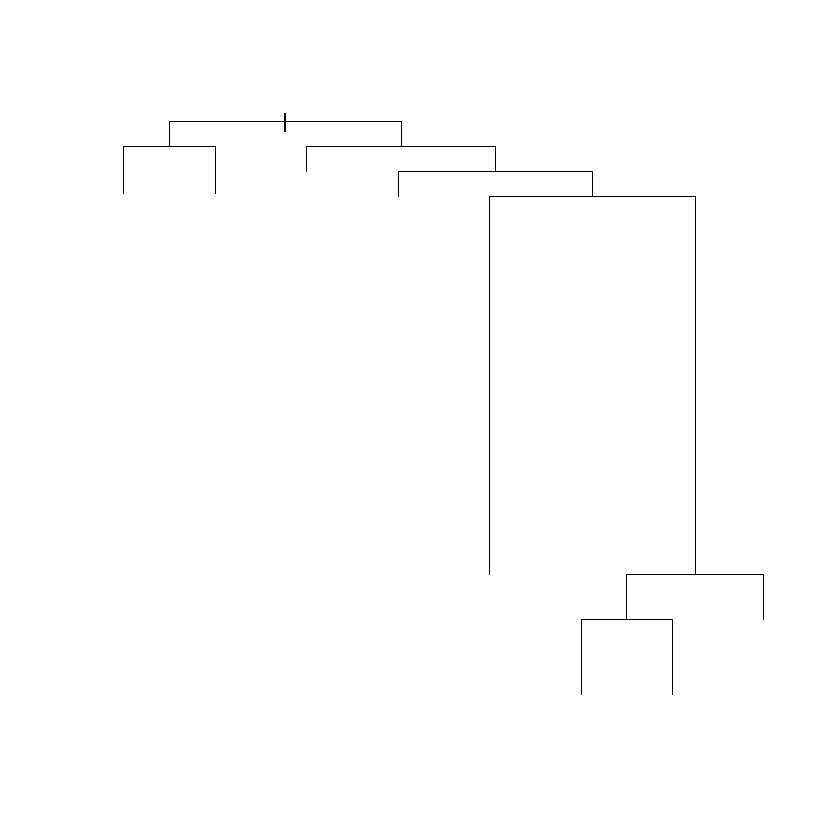

In [19]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]
tv<-rbind(train,val)
#Base Model
tmp_tree <- rpart(damage_grade ~ ., data = tv, method = "class")

#Plot Decision Tree
plot(tmp_tree)
#control=rpart.control(minsplit=2, cp=0,maxdepth = 8
tmp_tree$cptable

In [46]:
nsplit <-c(0,4,6,7 )
hyper<-matrix(0,ncol=3,nrow=4)
colnames(hyper)<-c("nsplit","acc","bcr")
t<-1
for(i in nsplit){
    hr_model_preprun <- rpart(damage_grade ~ ., data = tv, method = "class",  control = rpart.control(minsplit = i))
    prediction <- predict(hr_model_preprun,test)
    # prediction결과가 같 class가 나올 확률로 나오므로, max.col 함수를 사용한다
    tst_cm <- table(c(1,2,3,max.col(prediction)),c(1,2,3 ,test$damage_grade))
    diag(tst_cm) <- diag(tst_cm)-1
    hyper[t,]<-c(i,perf_eval_multi(tst_cm))
    t<-t+1
}

In [47]:
hyper
# 아래 값들이 모두 동일한 결과가 나왔기에, cp에 대해서도 동일하게 수행해본다

nsplit,acc,bcr
0,0.6454043,0.6434247
1,0.6454043,0.6434247
2,0.6454043,0.6434247
3,0.6454043,0.6434247
4,0.6454043,0.6434247
5,0.6454043,0.6434247
6,0.6454043,0.6434247
7,0.6454043,0.6434247
8,0.6454043,0.6434247
9,0.6454043,0.6434247


In [21]:
cp <-c(0.001,0.0015,0.002,0.005,0.01)
hyper2<-matrix(0,ncol=3,nrow=length(cp))
colnames(hyper2)<-c("cp","acc","bcr")
t<-1
for(i in cp){
    hr_model_preprun <- rpart(damage_grade ~ ., data = tv, method = "class",  control = rpart.control(cp= i))
    prediction <- predict(hr_model_preprun,test)
    # prediction결과가 같 class가 나올 확률로 나오므로, max.col 함수를 사용한다
    tst_cm <- table(c(1,2,3,max.col(prediction)),c(1,2,3 ,test$damage_grade))
    diag(tst_cm) <- diag(tst_cm)-1
    hyper2[t,]<-c(i,perf_eval_multi(tst_cm))
    t<-t+1
}

In [22]:
hyper2# 이 코드의 실행 결과 를 보면 cp = 0.001 일 때 가장 높은 bcr를 보이기에, cp = 0.001로 정하겠습니다

cp,acc,bcr
0.0010,0.6758778,0.6672528
0.0015,0.6695378,0.6682216
0.0020,0.6627111,0.6350469
0.0050,0.6454043,0.6434247
0.0100,0.6454043,0.6434247


In [ ]:
hr_model_preprun <- rpart(damage_grade ~ ., data = tv, method = "class",  control = rpart.control(cp= 0.001))
prediction <- predict(hr_model_preprun,test)
    # prediction결과가 같 class가 나올 확률로 나오므로, max.col 함수를 사용한다
tst_cm <- table(c(1,2,3,max.col(prediction)),c(1,2,3 ,test$damage_grade))
diag(tst_cm) <- diag(tst_cm)-1
perf_summary[2,]<-perf_eval_multi(tst_cm)

In [23]:
perf_summary[2,] <- hyper2[1,c(2:3)]
perf_summary

,ACC,BCR
MLR,0.5923239,0.3760061
CART,0.6758778,0.6672528
ANN,0.0000000,0.0000000
CART bagging,0.0000000,0.0000000
ANN bagging,0.0000000,0.0000000
random forest,0.0000000,0.0000000
adaboost,0.0000000,0.0000000
GBA,0.0000000,0.0000000


## 3. ANN : Hyper parameter 바꾸기
nh는 히든 노드 수 를 나타냄으로 성능을 좌우하기 때문에 하이퍼파라미터로 선정했고, maxit은 최대 얼마나 반복하는지를 의미하고 이를 
1. size = nH : 12,14,16,18,20,22,24,26
2. max iteration = 100,200,300,400

와 같이 반복하겠습니다: 저번시간에 구한 파라미터를 참조하여, 성능이 낮게 나온 파라미터는 제외했습니다

### 결론 : size = 24, maxit = 300

In [24]:
# Candidate hidden nodes
nH <- seq(from=12, to=26, by=2) # 총 9개
mit<- seq(from=100, to=400, by=100) # 총 5개
# 5-fold cross validation index
val_idx <- sample(c(1:5), dim(trn_data_x)[1], replace = TRUE, prob = rep(0.2,5))
val_perf <- matrix(0, length(nH)*length(mit), 4)

In [26]:
ptm <- proc.time()
num <-1
for (i in 1:length(nH)) {
  cat("Training ANN: the number of hidden nodes:", nH[i], "\n")
  eval_fold <- c()
  
  for (k in 1:length(mit)) {
    cat("num:",num,"nh:",nH[i],"max iter:",mit[k],"\n")
    tmp_nnet <- nnet(trn_data_x, trn_data_y, size = nH[i], decay = 5e-4, maxit = mit[k],MaxNWts=999999)
    prey <- predict(tmp_nnet, tst_data_x)
    cfm <- table(c(max.col(tst_data_y),1,2,3), c(max.col(prey) ,1,2,3) )
    diag(cfm) <- diag(cfm)-1
    val_perf[num,1] <-nH[i]
    val_perf[num,2] <-mit[k]
    # Record the validation performance
    val_perf[num,3:4] <- perf_eval_multi(cfm)
    num <- num + 1
  } 
}
proc.time() - ptm

Training ANN: the number of hidden nodes: 12 
num: 1 nh: 12 max iter: 100 
# weights:  771
initial  value 29648.391618 
iter  10 value 25290.769878
iter  20 value 24328.457296
iter  30 value 23880.979081
iter  40 value 23636.085424
iter  50 value 23337.089410
iter  60 value 23011.022918
iter  70 value 22806.880692
iter  80 value 22611.407984
iter  90 value 22481.749943
iter 100 value 22385.309438
final  value 22385.309438 
stopped after 100 iterations
num: 2 nh: 12 max iter: 200 
# weights:  771
initial  value 50946.815399 
iter  10 value 27149.728957
iter  20 value 25985.712293
iter  30 value 25522.917344
iter  40 value 25296.913517
iter  50 value 24888.164314
iter  60 value 24610.609751
iter  70 value 24438.641370
iter  80 value 24176.940807
iter  90 value 23564.475560
iter 100 value 23148.277401
iter 110 value 22927.182011
iter 120 value 22731.176485
iter 130 value 22620.023132
iter 140 value 22552.174797
iter 150 value 22495.358405
iter 160 value 22448.437782
iter 170 value 22416.8

initial  value 33628.301203 
iter  10 value 25778.568922
iter  20 value 24593.179776
iter  30 value 23964.075414
iter  40 value 23725.803880
iter  50 value 23494.210449
iter  60 value 23326.629949
iter  70 value 23176.234773
iter  80 value 23016.032909
iter  90 value 22879.998263
iter 100 value 22785.636561
iter 110 value 22711.908509
iter 120 value 22655.244687
iter 130 value 22614.877615
iter 140 value 22557.416143
iter 150 value 22514.082879
iter 160 value 22475.843714
iter 170 value 22422.021147
iter 180 value 22375.199371
iter 190 value 22332.315205
iter 200 value 22291.817172
iter 210 value 22249.278901
iter 220 value 22212.296473
iter 230 value 22175.110597
iter 240 value 22141.424295
iter 250 value 22116.540129
iter 260 value 22097.239469
iter 270 value 22083.849089
iter 280 value 22074.525490
iter 290 value 22067.548728
iter 300 value 22060.800628
iter 310 value 22054.927125
iter 320 value 22049.171355
iter 330 value 22045.215403
iter 340 value 22039.769219
iter 350 value 2203

initial  value 44584.567336 
iter  10 value 42090.578181
iter  20 value 39870.121253
iter  30 value 35955.899093
iter  40 value 33941.057996
iter  50 value 33432.659595
iter  60 value 33130.866917
iter  70 value 32862.168566
iter  80 value 32610.754738
iter  90 value 32485.497293
iter 100 value 32423.384539
iter 110 value 32386.326169
iter 120 value 32350.424109
iter 130 value 32315.542833
iter 140 value 32290.808054
iter 150 value 32261.398540
iter 160 value 32192.942680
iter 170 value 32142.736931
iter 180 value 32114.833734
iter 190 value 32097.975106
iter 200 value 32085.806270
final  value 32085.806270 
stopped after 200 iterations
num: 23 nh: 22 max iter: 300 
# weights:  1411
initial  value 49608.800795 
iter  10 value 43106.700936
iter  20 value 42726.351264
iter  30 value 40804.870092
iter  40 value 38302.383754
iter  50 value 36408.229552
iter  60 value 35594.204946
iter  70 value 35300.375580
iter  80 value 35132.006603
iter  90 value 35012.954496
iter 100 value 34965.258239

initial  value 62444.776181 
iter  10 value 43068.498757
iter  20 value 42957.936178
iter  30 value 42605.475062
iter  40 value 42198.286750
iter  50 value 41542.229572
iter  60 value 41016.015391
iter  70 value 40596.635894
iter  80 value 39865.320385
iter  90 value 39050.235462
iter 100 value 38679.056188
iter 110 value 38446.137393
iter 120 value 38306.822016
iter 130 value 38180.662670
iter 140 value 37882.667706
iter 150 value 37625.943382
iter 160 value 37449.709481
iter 170 value 37334.705555
iter 180 value 37210.808228
iter 190 value 37111.809833
iter 200 value 37017.001397
iter 210 value 36931.991318
iter 220 value 36760.329787
iter 230 value 36586.789476
iter 240 value 36198.389806
iter 250 value 36040.829823
iter 260 value 35960.525888
iter 270 value 35888.981528
iter 280 value 35831.134529
iter 290 value 35798.980749
iter 300 value 35756.439875
iter 310 value 35730.042609
iter 320 value 35698.144055
iter 330 value 35676.663968
iter 340 value 35655.506568
iter 350 value 3562

   user  system elapsed 
4476.17    3.32 4510.19 

In [27]:
ordered_val_perf <- val_perf[order(val_perf[,4], decreasing = TRUE),]
colnames(ordered_val_perf) <- c("nH","maxit", "ACC", "BCR")
head(ordered_val_perf)
tail(ordered_val_perf)

nH,maxit,ACC,BCR
24,300,0.6388909,0.5427810
26,200,0.6578177,0.5239263
26,100,0.6542310,0.5206112
20,300,0.6563577,0.5197722
24,200,0.6511910,0.5192406
18,100,0.6550910,0.5180885


,nH,maxit,ACC,BCR
"[27,]",18,200,0.6250575,0
"[28,]",20,100,0.5675171,0
"[29,]",22,200,0.5675171,0
"[30,]",22,300,0.5675171,0
"[31,]",22,400,0.5675105,0
"[32,]",26,400,0.5675171,0


In [28]:
perf_summary[3,] <- ordered_val_perf[1,c(3:4)]
perf_summary

,ACC,BCR
MLR,0.5923239,0.3760061
CART,0.6758778,0.6672528
ANN,0.6388909,0.5427810
CART bagging,0.0000000,0.0000000
ANN bagging,0.0000000,0.0000000
random forest,0.0000000,0.0000000
adaboost,0.0000000,0.0000000
GBA,0.0000000,0.0000000


# A2 : CART Bagging

Tree의 수는 CART Bagging과 Random Forest는 성능 차이에 영향을 미친다 고 볼 수 있는가

In [14]:
library(ipred)
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]
tv<-rbind(train,val)

In [15]:
str(tv)

'data.frame':	110602 obs. of  39 variables:
 $ geo_level_1_id                        : int  30 17 17 4 3 26 8 6 7 20 ...
 $ geo_level_2_id                        : int  266 409 716 651 1387 1132 1297 398 555 508 ...
 $ geo_level_3_id                        : int  1224 12182 7056 105 3909 6645 9721 4512 2763 10459 ...
 $ count_floors_pre_eq                   : int  1 2 2 2 5 2 2 2 3 2 ...
 $ age                                   : int  25 0 5 80 40 0 0 30 40 5 ...
 $ area_percentage                       : int  5 13 12 5 5 6 2 10 5 7 ...
 $ height_percentage                     : int  2 7 6 4 10 6 6 5 6 6 ...
 $ has_superstructure_adobe_mud          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_stone   : int  1 1 1 1 0 0 1 1 1 1 ...
 $ has_superstructure_stone_flag         : int  0 0 0 0 0 0 1 0 0 0 ...
 $ has_superstructure_cement_mortar_stone: int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_brick   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ has_superstructure_ce

### majority votes

In [25]:
Mode <- function(x) {
   ux <- unique(x)
   ux[which.max(tabulate(match(x, ux)))]
 }

bag.trees <- function(B) # B is the number of bootstrap samples
{
  pred.mat <- matrix(NA, nrow = nrow(test), ncol = B)
  bcc <-c(1:B)
  acc <-c(1:B)
  for(i in 1:B){ 
    indices <- sample(1:nrow(train),nrow(train),replace=TRUE)
    sample <- train[indices,]

    model_bag <- rpart(damage_grade ~ ., data = sample, method = "class",  control = rpart.control(cp= 0.001))
    prediction <- predict(model_bag,test)
        # prediction결과가 같 class가 나올 확률로 나오므로, max.col 함수를 사용한다
    tst_cm <- table(c(1,2,3,max.col(prediction)),c(1,2,3 ,test$damage_grade))
    diag(tst_cm) <- diag(tst_cm)-1
    acc[i] <-perf_eval_multi(tst_cm)[1]
    bcc[i] <-perf_eval_multi(tst_cm)[2]
    pred.mat[,i] <- max.col(prediction)
  }
   
# majority vote
  result <- apply(pred.mat, 1, Mode)
  result <- as.vector(result)
  return(result)
}

In [26]:
total <- matrix(0,nrow=nrow(test),ncol=10)

In [ ]:
nb <- seq(from=30, to=300, by=30)

t<-1
for( i in nb){
    set.seed(i)
    bag <- bag.trees(i)
    total[,t]<- bag
    t<-t+1
}

In [ ]:
total_perf <- matrix(0,nrow=10,ncol=3)
for( i in 1:10 ){
    tst_cm <- table(total[,i] ,test$damage_grade)
    a<-perf_eval_multi(tst_cm)
    total_perf[i,] <-c(nb[i],a)
}

In [ ]:
colnames(total_perf)<-c("ntree","acc","bcr")

In [ ]:
total_perf

#### cart single model vs cart bagging - by majority votes
총 10번의 시도중 ntree가 20일때를 제외하고 그냥 cart 모델보다 성능이 항상된 것을 볼 수 있습니다. 하지만 그 항상 정도가 1% 내외임으로 엄청난 항상은 아닌 것 같습니다.

### weighted votes - by acc

In [ ]:
# changed a bit

Mode <- function(x) {
   ux <- unique(x)
   ux[which.max(tabulate(match(x, ux)))]
 }

bag.trees.acc <- function(B) # B is the number of bootstrap samples
{
  pred.mat <- matrix(NA, nrow = nrow(test), ncol = B)
  bcc <-c(1:B)
  acc <-c(1:B)
  for(i in 1:B){ 
    indices <- sample(1:nrow(train),nrow(train),replace=TRUE)
    sample <- train[indices,]

    model_bag <- rpart(damage_grade ~ ., data = sample, method = "class",  control = rpart.control(cp= 0.001))
    prediction <- predict(model_bag,test)
        # prediction결과가 같 class가 나올 확률로 나오므로, max.col 함수를 사용한다
    tst_cm <- table(c(1,2,3,max.col(prediction)),c(1,2,3 ,test$damage_grade))
    diag(tst_cm) <- diag(tst_cm)-1
    acc[i] <-perf_eval_multi(tst_cm)[1]
    bcc[i] <-perf_eval_multi(tst_cm)[2]
    pred.mat[,i] <- max.col(prediction)
  }
   acc <- acc/sum(acc)
   acc <- as.vector(acc)
   pred.mat2 <-  rowSums(  t(pred.mat) * acc )
   pred.mat <- as.table(pred.mat2)
   result <- round(pred.mat2) 
  return(result)
}

In [ ]:
total2 <- matrix(0,nrow=nrow(test),ncol=10)
nb <- seq(from=30, to=300, by=30)
t<-1
for( i in nb){
    set.seed(i)
    bag <- bag.trees.acc(i)
    total2[,t]<- bag
    t<-t+1
}

In [ ]:
total_perf2 <- matrix(0,nrow=10,ncol=3)
colnames(total_perf2)<-c("ntree","acc","bcr")
for( i in 1:10 ){
    tst_cm <- table(total2[,i] ,test$damage_grade)
    a<-perf_eval_multi(tst_cm)
    total_perf2[i,] <-c(nb[i],a)
}

In [ ]:
total_perf2

#### cart single model vs cart bagging - by weighted votes

# A3: Random Forest


1. 최적의 boostrap 수

`val_perf_rf[order(val_perf_rf[,3], decreasing = TRUE),]` code를 실행한 결과 240 boostrap이 가장 최적으로 나왔습니다


2. 최적의 tree수 기준으로 이 데이터셋에 대해서는 cart bagging vs random forest?



3. 각 tree(boostrap)수 마다 cart bagging 모형과의 분류 정확도를 비교할 수 있는 그래프 도시하시오 Tree의 수는 CART Bagging과 Random Forest는 성능 차이에 영향을 미친다고 볼 수 있는가


In [63]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]
tv<-rbind(train,val)

RF.trn <- tv
RF.tst <- test


val_perf_rf <- matrix(0, nrow = 10, ncol=3)
colnames(val_perf_rf)<-c("boosting","acc","bcr")


In [ ]:
# pivot 실행
ptm <- proc.time()
RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree = 30, importance = TRUE, do.trace = TRUE)
RF.Time <- proc.time() - ptm
RF.Time
# Check the result
print(RF.model)
plot(RF.model)

# Prediction
RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
RF.cfm <- table(RF.prey, RF.tst$damage_grade)


In [ ]:
val_perf_rf[1,]<- c(i,perf_eval_multi(RF.cfm[,c(1:3)]) )
print(val_perf_rf[t,])
t<-t+1

In [ ]:
# 반복실행

In [ ]:
nb2 <- seq(from=30, to=300, by=30)
t<-1
for(i in nb2){
    # Training the Random Forest
    RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree = i, importance = TRUE, do.trace = TRUE)
    # Prediction
    RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
    RF.cfm <- table(RF.prey, RF.tst$damage_grade)
    val_perf_rf[t,]<- c(i,perf_eval_multi(RF.cfm[,c(1:3)]) )
    print(val_perf_rf[t,])
    t<-t+1
}

In [ ]:
val_perf_rf[order(val_perf_rf[,3], decreasing = TRUE),]

In [ ]:
perf_summary[6,] <- val_perf_rf[order(val_perf_rf[,3], decreasing = TRUE),][1,c(2:3)]

#### 위에서 얻은 결과를 바탕으로 240이 가장 좋은 결과를 가졌고, 이의  변수 중요도를 알기 위해 다시 모델 생성하면 아래와 같습니다.

In [64]:
RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree =240, importance = TRUE, do.trace = TRUE)
# Prediction
RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
RF.cfm <- table(RF.prey, RF.tst$damage_grade)
Var.imp <- importance(RF.model)

ntree      OOB      1      2      3
    1:  36.92% 55.22% 30.98% 41.91%
    2:  37.88% 55.06% 30.83% 45.03%
    3:  37.99% 54.47% 30.58% 45.98%
    4:  37.36% 53.75% 29.71% 45.74%
    5:  36.87% 53.86% 28.42% 46.43%
    6:  36.42% 54.02% 27.80% 46.09%
    7:  35.71% 53.97% 26.97% 45.41%
    8:  34.93% 54.07% 26.03% 44.65%
    9:  34.48% 53.98% 25.28% 44.64%
   10:  34.08% 54.46% 24.51% 44.61%
   11:  33.64% 54.42% 23.87% 44.38%
   12:  33.27% 54.38% 23.30% 44.27%
   13:  32.91% 54.12% 22.91% 43.93%
   14:  32.53% 54.45% 22.41% 43.57%
   15:  32.30% 54.40% 21.96% 43.67%
   16:  31.97% 54.20% 21.53% 43.46%
   17:  31.75% 54.60% 21.22% 43.21%
   18:  31.62% 54.58% 20.94% 43.31%
   19:  31.45% 54.58% 20.56% 43.46%
   20:  31.35% 54.64% 20.51% 43.21%
   21:  31.13% 54.40% 20.21% 43.14%
   22:  30.93% 54.73% 19.81% 43.12%
   23:  30.94% 54.94% 19.72% 43.25%
   24:  30.81% 55.01% 19.64% 42.98%
   25:  30.71% 55.14% 19.51% 42.87%
   26:  30.59% 55.34% 19.24% 42.90%
   27:  30.47% 55.03% 19.18%

In [65]:
df <-Var.imp[order(Var.imp[,4], decreasing = TRUE),4]

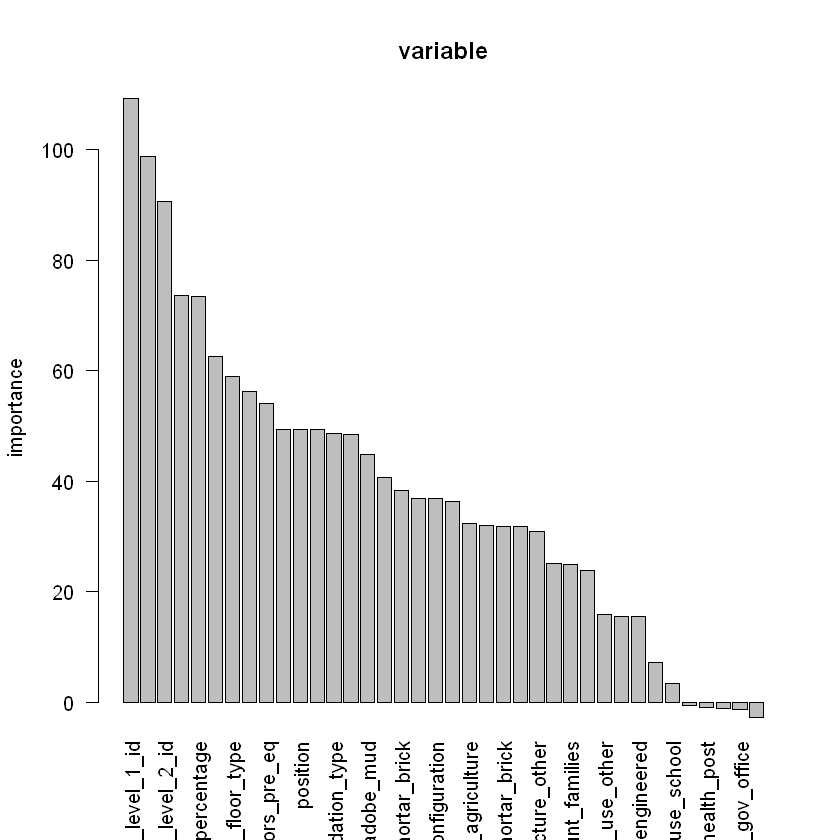

In [56]:
barplot(df,main="variable",ylab="importance",las=2)

In [66]:
Var.imp

,1,2,3,MeanDecreaseAccuracy,MeanDecreaseGini
geo_level_1_id,80.898839,96.3650876,111.4600760,118.18884233,7267.590861
geo_level_2_id,58.892289,72.8360705,77.9965087,90.39014986,5327.083681
geo_level_3_id,50.496285,61.4628130,74.8582523,91.99722364,5190.796691
count_floors_pre_eq,23.430610,34.1389216,30.7448362,52.32697327,906.232398
age,74.098582,19.1681618,34.6034417,63.67515105,3418.053182
area_percentage,28.164931,55.5611920,44.4334823,68.54609253,3434.401403
height_percentage,22.184372,55.0143681,40.9231688,63.57424828,2204.967516
has_superstructure_adobe_mud,22.190825,20.7771837,34.3455279,45.47512673,412.004762
has_superstructure_mud_mortar_stone,33.718811,18.2564978,26.8339827,36.16691906,837.142715
has_superstructure_stone_flag,25.768768,24.1804702,35.8946884,41.01917588,293.979483


# cart bagging vs random foresest plot

# A4: ANN 30회 반복

In [29]:
val_perf2 <- matrix(0, 30, 3)
colnames(val_perf2)<-c("n","acc","bcr")
ptm <- proc.time()
num <-1  
for (k in 1:30) {
    tmp_nnet <- nnet(trn_data_x, trn_data_y, size = 24, decay = 5e-4, maxit = 300,MaxNWts=999999)
    prey <- predict(tmp_nnet, tst_data_x)
    cfm <- table(c(max.col(tst_data_y),1,2,3), c(max.col(prey) ,1,2,3) )
    diag(cfm) <- diag(cfm)-1
    # Record the validation performance
    val_perf2[num,2:3] <- perf_eval_multi(cfm)
    num <- num + 1 
}
proc.time() - ptm

# weights:  1539
initial  value 56197.957983 
iter  10 value 42841.901018
iter  20 value 41019.626675
iter  30 value 36821.239634
iter  40 value 36019.521115
iter  50 value 35401.442062
iter  60 value 34986.327812
iter  70 value 34921.248904
iter  80 value 34886.500019
iter  90 value 34856.268549
iter 100 value 34825.067117
iter 110 value 34800.052171
iter 120 value 34786.516320
iter 130 value 34774.251834
iter 140 value 34767.616544
iter 150 value 34741.725374
iter 160 value 34726.876693
iter 170 value 34702.240711
iter 180 value 34672.282956
iter 190 value 34617.557703
iter 200 value 34563.057081
iter 210 value 34527.833977
iter 220 value 34469.438696
iter 230 value 34430.384882
iter 240 value 34406.944355
iter 250 value 34383.173421
iter 260 value 34357.456172
iter 270 value 34328.493575
iter 280 value 34298.623383
iter 290 value 34279.062563
iter 300 value 34254.452331
final  value 34254.452331 
stopped after 300 iterations
# weights:  1539
initial  value 37225.421072 
iter  10 val

initial  value 63241.159031 
iter  10 value 43068.924590
iter  20 value 43063.868913
iter  30 value 43047.234285
iter  40 value 33044.528321
iter  50 value 31957.335354
iter  60 value 31645.506786
iter  70 value 31395.212656
iter  80 value 31207.183833
iter  90 value 31068.516742
iter 100 value 30910.395330
iter 110 value 30750.287535
iter 120 value 30596.016339
iter 130 value 30503.513201
iter 140 value 30420.887614
iter 150 value 30361.568852
iter 160 value 30324.698023
iter 170 value 30288.724804
iter 180 value 30262.270223
iter 190 value 30237.887162
iter 200 value 30218.030641
iter 210 value 30193.551839
iter 220 value 30176.887258
iter 230 value 30160.159270
iter 240 value 30138.303125
iter 250 value 30113.318476
iter 260 value 30099.674193
iter 270 value 30086.330795
iter 280 value 30074.645800
iter 290 value 30063.681430
iter 300 value 30056.782427
final  value 30056.782427 
stopped after 300 iterations
# weights:  1539
initial  value 40672.457387 
iter  10 value 26617.209929
i

initial  value 32387.693652 
iter  10 value 25381.710103
iter  20 value 24267.043537
iter  30 value 23693.457349
iter  40 value 23131.232849
iter  50 value 22863.375153
iter  60 value 22586.630574
iter  70 value 22337.100221
iter  80 value 22068.473501
iter  90 value 21895.792193
iter 100 value 21775.913723
iter 110 value 21703.437332
iter 120 value 21632.239679
iter 130 value 21584.217329
iter 140 value 21545.626193
iter 150 value 21498.393792
iter 160 value 21447.637802
iter 170 value 21408.381017
iter 180 value 21381.717264
iter 190 value 21345.955009
iter 200 value 21318.869460
iter 210 value 21291.876337
iter 220 value 21270.127178
iter 230 value 21250.958277
iter 240 value 21237.862273
iter 250 value 21229.951017
iter 260 value 21224.468544
iter 270 value 21220.318892
iter 280 value 21217.176378
iter 290 value 21214.621582
iter 300 value 21212.366814
final  value 21212.366814 
stopped after 300 iterations
# weights:  1539
initial  value 47585.541237 
iter  10 value 42455.396783
i

initial  value 66491.133707 
iter  10 value 32997.507502
iter  20 value 25386.789486
iter  30 value 24283.755848
iter  40 value 23735.916042
iter  50 value 23329.453889
iter  60 value 23000.795003
iter  70 value 22755.535415
iter  80 value 22501.125900
iter  90 value 22279.338497
iter 100 value 22036.742137
iter 110 value 21875.621843
iter 120 value 21756.170737
iter 130 value 21659.977686
iter 140 value 21585.405912
iter 150 value 21522.002295
iter 160 value 21471.924812
iter 170 value 21426.209333
iter 180 value 21389.545471
iter 190 value 21358.092666
iter 200 value 21327.922552
iter 210 value 21308.552461
iter 220 value 21279.104899
iter 230 value 21251.942694
iter 240 value 21236.991807
iter 250 value 21228.263661
iter 260 value 21222.130574
iter 270 value 21217.356249
iter 280 value 21212.898194
iter 290 value 21204.107743
iter 300 value 21194.046898
final  value 21194.046898 
stopped after 300 iterations
# weights:  1539
initial  value 39655.207744 
iter  10 value 26191.972082
i

   user  system elapsed 
6376.41    4.47 6435.35 

In [41]:
val_perf2

n,acc,bcr
0,0.5672971,0.007682452
0,0.6552777,0.519214972
0,0.5675438,0.000000000
0,0.5675171,0.000000000
0,0.6502310,0.508492787
0,0.5752905,0.000000000
0,0.6151241,0.000000000
0,0.6540910,0.520469435
0,0.6567044,0.522009701
0,0.5774372,0.102373081


In [45]:
colMeans(val_perf2)

n       acc       bcr 
0.0000000 0.6195555 0.2874532

In [47]:
library(matrixStats)
colSds(val_perf2)


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count




[1] 0.00000000 0.03954806 0.25155596

우선 결과를 좀 살펴 보면, 극단적으로 어떤 class를 분류하지 못했을 경우가 존재했고, 그게 아니면 0.5~0.6 사이 값을 갔는다. 평균은 `colMeans(val_perf2)` 표본 표준 편자는 `colSds(val_perf2)`를 통해 각각
- mean
  - acc:0.612      
  - bcr: 0.287
- std
  - acc:0.040      
  - bcr: 0.252

# A5 : ANN bagging

In [108]:
# Assign the number of cores to be processed in parallel
cl <- makeCluster(4) # the number of cores
registerDoParallel(cl)
nb <- seq(from=30, to=300, by=30)
val_perf <- matrix(0, length(nb), 3)
colnames(val_perf)<-c("boosting","acc","bcr")


trn_idx <- c(1:50000)
val_idx<-c(50001:110602)
tst_idx<-c(110603:260601 )

trn_data_x <- ann_x[trn_idx,]
val_data_x <- ann_x[val_idx,]
tst_data_x <- ann_x[tst_idx,]

trn_data_y <- ann_y[trn_idx,]
val_data_y <- ann_y[val_idx,]
tst_data_y <- ann_y[tst_idx,]

s1<-sample(1:15000,5000)
trn_data_x.s <- ann_x[s1,]
trn_data_y.s <- ann_y[s1,]

#sampling된값.
ann.x = trn_data_x.s
ann.y = trn_data_y.s


i<-1
for(i in 1:10){
    Bagging.ANN.model <- avNNet(ann.x, ann.y, size = 10, decay = 5e-4,maxit=100,MaxNWts=99999,
                          repeats = nb[i], bag = TRUE, allowParallel = TRUE, trace = TRUE)
    Bagging.ANN.prey <- predict(Bagging.ANN.model, newdata = tst_data_x)
    cat(i)
    Bagging.ANN.cfm <- table( c(1,2,3,max.col(tst_data_y)), c(1,2,3,max.col(Bagging.ANN.prey)))
    diag(Bagging.ANN.cfm) <- diag(Bagging.ANN.cfm) -1
    Bagging.ANN.cfm
    val_perf[i,]<-c(nb[i],perf_eval_multi(Bagging.ANN.cfm))
    val_perf  
    
}


Warning message in 1:repeats:
"수치형 표현식(numerical expression)은 10개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."
Warning message in 1:object$repeats:
"수치형 표현식(numerical expression)은 10개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."
Warning message in scores/object$repeats:
"두 객체의 길이가 서로 배수관계에 있지 않습니다"


ERROR: Error in table(c(1, 2, 3, max.col(tst_data_y)), c(1, 2, 3, max.col(Bagging.ANN.prey))): all arguments must have the same length


In [ ]:
ordered_val_perf <- val_perf[order(val_perf[,4], decreasing = TRUE),]
perf_summary[5,] <- ordered_val_perf[1,c(2:3)]
perf_summary

# A6 : AdaBoost

In [ ]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]

var_perf_ada <- matrix(0, nrow = 10, ncol= 3)
colnames(var_perf_ada) <- c("n_tree","acc","bcc")
n_tree = nb <- seq(from=30, to=300, by=30)

for(i in 1:10){
    
    ada<-boosting(damage_grade ~., control = rpart.control(cp= 0.001) ,
                   data=train, mfinal=n_tree[i])
    ada.pred <- predict(ada,val[,-39])
    ada.pred.class <- ada.pred$class
    ada.cfm <- table(c(1,2,3, ada.pred.class), c(1,2,3,val$damage_grade))
    diag(ada.cfm) <- diag(ada.cfm) -1
    var_perf_ada[i,]<-c(n_tree[i],perf_eval_multi(ada.cfm))
}

In [ ]:
var_perf_ada

In [ ]:
tv = rbind(train,val)
ada<-boosting(damage_grade ~., control = rpart.control(cp= 0.001) ,
                   data=tv, mfinal=120)
ada.pred <- predict(ada,test[,-39])
ada.pred.class <- ada.pred$class
ada.cfm <- table(c(1,2,3, ada.pred.class), c(1,2,3,test$damage_grade))
diag(ada.cfm) <- diag(ada.cfm) -1
perf_summary[7,]<-c(perf_eval_multi(ada.cfm))
perf_summary

# A7: Gradient Boosting Machine

pivot running 으로 ntree가 10으로 실행해보니 너무 성능이 안좋아서 실제로는 30:300,30 씩 증가하도록 코드를 짰습니다

In [16]:
#pivot실행
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]

GBM.trn <- train
GBM.tst <- val 

GBM.model <- gbm.fit(GBM.trn[,-39], GBM.trn[,39], distribution = "multinomial", 
                         n.trees = 10, shrinkage = 0.02, bag.fraction = 0.7, nTrain = 1000)
        # Prediction
GBM.prey <- predict(GBM.model, GBM.tst[,-39], type = "response")
GBM.pre.max <- apply(GBM.prey, 1, which.max)
        
GBM.prey.max <- as.vector(GBM.pre.max)
        
GBM.cfm <- table(c(1,2,3, GBM.prey.max), c(1,2,3,GBM.tst$damage_grade))

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0200    0.0251
     2        1.0855          1.0862     0.0200    0.0222
     3        1.0725          1.0740     0.0200    0.0230
     4        1.0607          1.0628     0.0200    0.0207
     5        1.0490          1.0519     0.0200    0.0189
     6        1.0378          1.0415     0.0200    0.0191
     7        1.0279          1.0322     0.0200    0.0161
     8        1.0183          1.0233     0.0200    0.0172
     9        1.0089          1.0147     0.0200    0.0155
    10        1.0001          1.0065     0.0200    0.0152



Using 10 trees...




In [23]:
GBM.cfm

            
GBM.prey.max     1     2     3
           1   239   131     6
           2  5590 34503 20133

In [31]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]

GBM.trn <- train
GBM.tst <- val 

n_tree = nb <- seq(from=30, to=300, by=30)
sh = c(0.01,0.05,0.1)
var_perf_gbm <- matrix(0, nrow = 30, ncol= 4)
colnames(var_perf_gbm) <- c("n_tree","shrinkage","acc","bcc")

진짜 실행

In [37]:

t<-1
for(i in n_tree){
    for(j in sh){
        GBM.model <- gbm.fit(GBM.trn[,-39], GBM.trn[,39], distribution = "multinomial", 
                                 n.trees = i, shrinkage = j, bag.fraction = 0.7, nTrain = 1000)
                # Prediction
        GBM.prey <- predict(GBM.model, GBM.tst[,-39], type = "response")
        GBM.pre.max <- apply(GBM.prey, 1, which.max)

        GBM.prey.max <- as.vector(GBM.pre.max)

        GBM.cfm <- table(c(1,2,3, GBM.prey.max), c(1,2,3,GBM.tst$damage_grade))
        diag(GBM.cfm) <- diag(GBM.cfm) -1
        var_perf_gbm[t,]<-c(i,j,perf_eval_multi(GBM.cfm))
        cat(var_perf_gbm[t,])
        t<-t+1
    }
}

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0124
     2        1.0918          1.0922     0.0100    0.0118
     3        1.0852          1.0860     0.0100    0.0120
     4        1.0788          1.0801     0.0100    0.0121
     5        1.0727          1.0744     0.0100    0.0111
     6        1.0666          1.0687     0.0100    0.0109
     7        1.0605          1.0630     0.0100    0.0111
     8        1.0548          1.0577     0.0100    0.0105
     9        1.0491          1.0524     0.0100    0.0101
    10        1.0438          1.0473     0.0100    0.0101
    20        0.9965          1.0034     0.0100    0.0076
    30        0.9592          0.9691     0.0100    0.0052



Using 30 trees...




30 0.01 0.5732484 NaNIter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0583
     2        1.0661          1.0675     0.0500    0.0518
     3        1.0371          1.0402     0.0500    0.0457
     4        1.0117          1.0169     0.0500    0.0404
     5        0.9898          0.9970     0.0500    0.0346
     6        0.9700          0.9787     0.0500    0.0296
     7        0.9530          0.9628     0.0500    0.0252
     8        0.9371          0.9485     0.0500    0.0241
     9        0.9237          0.9364     0.0500    0.0205
    10        0.9114          0.9259     0.0500    0.0161
    20        0.8348          0.8591     0.0500    0.0071
    30        0.7991          0.8311     0.0500    0.0030



Using 30 trees...




30 0.05 0.5858553 0.6286557Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1063
     2        1.0354          1.0391     0.1000    0.0766
     3        0.9859          0.9936     0.1000    0.0664
     4        0.9499          0.9614     0.1000    0.0483
     5        0.9211          0.9357     0.1000    0.0392
     6        0.8985          0.9158     0.1000    0.0318
     7        0.8790          0.8981     0.1000    0.0258
     8        0.8639          0.8846     0.1000    0.0184
     9        0.8504          0.8736     0.1000    0.0185
    10        0.8390          0.8640     0.1000    0.0115
    20        0.7797          0.8182     0.1000    0.0005
    30        0.7525          0.8024     0.1000   -0.0011



Using 30 trees...




30 0.1 0.6328504 0.6415109Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0128
     2        1.0920          1.0924     0.0100    0.0131
     3        1.0854          1.0863     0.0100    0.0113
     4        1.0789          1.0802     0.0100    0.0119
     5        1.0727          1.0742     0.0100    0.0117
     6        1.0667          1.0686     0.0100    0.0112
     7        1.0608          1.0631     0.0100    0.0102
     8        1.0552          1.0579     0.0100    0.0107
     9        1.0496          1.0527     0.0100    0.0093
    10        1.0441          1.0474     0.0100    0.0102
    20        0.9964          1.0032     0.0100    0.0071
    40        0.9289          0.9413     0.0100    0.0046
    60        0.8847          0.9020     0.0100    0.0026



Using 60 trees...




60 0.01 0.574123 NaNIter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0625
     2        1.0662          1.0684     0.0500    0.0514
     3        1.0370          1.0410     0.0500    0.0445
     4        1.0113          1.0172     0.0500    0.0399
     5        0.9902          0.9975     0.0500    0.0364
     6        0.9708          0.9793     0.0500    0.0291
     7        0.9548          0.9647     0.0500    0.0274
     8        0.9394          0.9506     0.0500    0.0237
     9        0.9253          0.9380     0.0500    0.0224
    10        0.9130          0.9272     0.0500    0.0198
    20        0.8357          0.8612     0.0500    0.0065
    40        0.7761          0.8156     0.0500    0.0002
    60        0.7511          0.8006     0.0500    0.0001



Using 60 trees...




60 0.05 0.634286 0.6471327Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1091
     2        1.0344          1.0376     0.1000    0.0802
     3        0.9867          0.9936     0.1000    0.0615
     4        0.9503          0.9610     0.1000    0.0495
     5        0.9203          0.9339     0.1000    0.0287
     6        0.8973          0.9131     0.1000    0.0276
     7        0.8792          0.8974     0.1000    0.0191
     8        0.8629          0.8825     0.1000    0.0154
     9        0.8489          0.8711     0.1000    0.0173
    10        0.8377          0.8619     0.1000    0.0142
    20        0.7776          0.8132     0.1000    0.0021
    40        0.7343          0.7914     0.1000   -0.0005
    60        0.7084          0.7812     0.1000   -0.0026



Using 60 trees...




60 0.1 0.6346985 0.6259595Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0122
     2        1.0917          1.0921     0.0100    0.0129
     3        1.0852          1.0861     0.0100    0.0125
     4        1.0789          1.0803     0.0100    0.0113
     5        1.0726          1.0744     0.0100    0.0113
     6        1.0665          1.0687     0.0100    0.0108
     7        1.0605          1.0631     0.0100    0.0104
     8        1.0548          1.0577     0.0100    0.0105
     9        1.0493          1.0525     0.0100    0.0095
    10        1.0439          1.0473     0.0100    0.0095
    20        0.9965          1.0032     0.0100    0.0077
    40        0.9296          0.9418     0.0100    0.0049
    60        0.8854          0.9025     0.0100    0.0030
    80        0.8548          0.8761     0.0100    0.0017
    90        0.8430          0.8660     0.0100    0.0013



Using 90 trees...




90 0.01 0.574651 NaNIter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0582
     2        1.0651          1.0666     0.0500    0.0479
     3        1.0358          1.0394     0.0500    0.0482
     4        1.0125          1.0179     0.0500    0.0357
     5        0.9905          0.9975     0.0500    0.0350
     6        0.9707          0.9789     0.0500    0.0336
     7        0.9541          0.9640     0.0500    0.0291
     8        0.9390          0.9503     0.0500    0.0238
     9        0.9250          0.9377     0.0500    0.0165
    10        0.9128          0.9265     0.0500    0.0204
    20        0.8353          0.8591     0.0500    0.0040
    40        0.7778          0.8155     0.0500    0.0019
    60        0.7514          0.7993     0.0500   -0.0003
    80        0.7345          0.7908     0.0500   -0.0010
    90        0.7271          0.7879     0.0500   -0.0006



Using 90 trees...




90 0.05 0.6370417 0.6396635Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1094
     2        1.0355          1.0385     0.1000    0.0782
     3        0.9860          0.9932     0.1000    0.0610
     4        0.9502          0.9601     0.1000    0.0506
     5        0.9209          0.9344     0.1000    0.0405
     6        0.8984          0.9145     0.1000    0.0277
     7        0.8793          0.8971     0.1000    0.0218
     8        0.8632          0.8831     0.1000    0.0159
     9        0.8494          0.8713     0.1000    0.0155
    10        0.8385          0.8615     0.1000    0.0142
    20        0.7799          0.8176     0.1000    0.0017
    40        0.7341          0.7905     0.1000   -0.0060
    60        0.7099          0.7822     0.1000   -0.0044
    80        0.6931          0.7779     0.1000   -0.0041
    90        0.6855          0.7786     0.1000   -0.0035



Using 80 trees...




90 0.1 0.6371407 0.6231391Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0127
     2        1.0919          1.0922     0.0100    0.0119
     3        1.0854          1.0861     0.0100    0.0120
     4        1.0790          1.0801     0.0100    0.0115
     5        1.0727          1.0742     0.0100    0.0112
     6        1.0668          1.0686     0.0100    0.0108
     7        1.0609          1.0631     0.0100    0.0113
     8        1.0551          1.0578     0.0100    0.0105
     9        1.0496          1.0526     0.0100    0.0098
    10        1.0442          1.0475     0.0100    0.0095
    20        0.9963          1.0031     0.0100    0.0074
    40        0.9291          0.9418     0.0100    0.0049
    60        0.8852          0.9025     0.0100    0.0030
    80        0.8551          0.8766     0.0100    0.0022
   100        0.8329          0.8577     0.0100    0.0012
   120        0.8161          0.8440     0.010

Using 120 trees...




120 0.01 0.5755751 0.4843725Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0614
     2        1.0659          1.0681     0.0500    0.0510
     3        1.0371          1.0411     0.0500    0.0466
     4        1.0128          1.0188     0.0500    0.0365
     5        0.9903          0.9978     0.0500    0.0327
     6        0.9706          0.9798     0.0500    0.0283
     7        0.9524          0.9629     0.0500    0.0252
     8        0.9377          0.9491     0.0500    0.0232
     9        0.9238          0.9362     0.0500    0.0206
    10        0.9119          0.9254     0.0500    0.0175
    20        0.8341          0.8577     0.0500    0.0066
    40        0.7767          0.8132     0.0500    0.0009
    60        0.7503          0.7973     0.0500   -0.0006
    80        0.7339          0.7902     0.0500   -0.0006
   100        0.7204          0.7848     0.0500   -0.0006
   120        0.7083          0.7819     0.0

Using 120 trees...




120 0.05 0.6367777 0.6366485Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1131
     2        1.0357          1.0402     0.1000    0.0824
     3        0.9877          0.9952     0.1000    0.0633
     4        0.9515          0.9615     0.1000    0.0519
     5        0.9218          0.9343     0.1000    0.0411
     6        0.8981          0.9135     0.1000    0.0331
     7        0.8788          0.8964     0.1000    0.0257
     8        0.8624          0.8821     0.1000    0.0161
     9        0.8497          0.8711     0.1000    0.0165
    10        0.8377          0.8605     0.1000    0.0129
    20        0.7776          0.8113     0.1000    0.0000
    40        0.7330          0.7873     0.1000   -0.0035
    60        0.7101          0.7804     0.1000   -0.0034
    80        0.6930          0.7799     0.1000   -0.0042
   100        0.6791          0.7780     0.1000   -0.0017
   120        0.6679          0.7788     0.1

Using 112 trees...




120 0.1 0.6351276 0.6173231Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0117
     2        1.0917          1.0920     0.0100    0.0124
     3        1.0851          1.0858     0.0100    0.0120
     4        1.0786          1.0796     0.0100    0.0112
     5        1.0725          1.0738     0.0100    0.0120
     6        1.0664          1.0681     0.0100    0.0107
     7        1.0603          1.0625     0.0100    0.0104
     8        1.0545          1.0570     0.0100    0.0101
     9        1.0488          1.0516     0.0100    0.0097
    10        1.0432          1.0464     0.0100    0.0102
    20        0.9961          1.0028     0.0100    0.0074
    40        0.9282          0.9408     0.0100    0.0043
    60        0.8849          0.9019     0.0100    0.0027
    80        0.8546          0.8754     0.0100    0.0018
   100        0.8328          0.8571     0.0100    0.0015
   120        0.8163          0.8436     0.01

Using 150 trees...




150 0.01 0.5842051 0.6516333Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0538
     2        1.0648          1.0668     0.0500    0.0525
     3        1.0366          1.0401     0.0500    0.0465
     4        1.0120          1.0173     0.0500    0.0417
     5        0.9902          0.9975     0.0500    0.0314
     6        0.9709          0.9795     0.0500    0.0308
     7        0.9536          0.9636     0.0500    0.0274
     8        0.9384          0.9501     0.0500    0.0220
     9        0.9243          0.9372     0.0500    0.0230
    10        0.9123          0.9262     0.0500    0.0170
    20        0.8348          0.8583     0.0500    0.0068
    40        0.7771          0.8141     0.0500    0.0013
    60        0.7516          0.7984     0.0500   -0.0004
    80        0.7336          0.7907     0.0500   -0.0007
   100        0.7203          0.7844     0.0500   -0.0013
   120        0.7102          0.7825     0.0

Using 146 trees...




150 0.05 0.6380152 0.6314354Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1064
     2        1.0338          1.0386     0.1000    0.0808
     3        0.9868          0.9945     0.1000    0.0650
     4        0.9507          0.9606     0.1000    0.0462
     5        0.9210          0.9339     0.1000    0.0407
     6        0.8975          0.9131     0.1000    0.0232
     7        0.8776          0.8952     0.1000    0.0222
     8        0.8624          0.8812     0.1000    0.0210
     9        0.8490          0.8697     0.1000    0.0162
    10        0.8378          0.8602     0.1000    0.0111
    20        0.7795          0.8158     0.1000   -0.0000
    40        0.7347          0.7910     0.1000   -0.0042
    60        0.7111          0.7809     0.1000   -0.0017
    80        0.6933          0.7805     0.1000   -0.0030
   100        0.6789          0.7786     0.1000   -0.0041
   120        0.6675          0.7795     0.1

Using 127 trees...




150 0.1 0.63455 0.6121543Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0126
     2        1.0918          1.0923     0.0100    0.0126
     3        1.0853          1.0860     0.0100    0.0116
     4        1.0789          1.0801     0.0100    0.0116
     5        1.0726          1.0742     0.0100    0.0116
     6        1.0667          1.0686     0.0100    0.0107
     7        1.0606          1.0630     0.0100    0.0103
     8        1.0548          1.0575     0.0100    0.0103
     9        1.0493          1.0523     0.0100    0.0101
    10        1.0437          1.0472     0.0100    0.0100
    20        0.9962          1.0030     0.0100    0.0075
    40        0.9288          0.9413     0.0100    0.0043
    60        0.8848          0.9019     0.0100    0.0031
    80        0.8544          0.8754     0.0100    0.0017
   100        0.8328          0.8572     0.0100    0.0010
   120        0.8162          0.8436     0.0100

Using 180 trees...




180 0.01 0.6071087 0.6447359Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0598
     2        1.0656          1.0673     0.0500    0.0489
     3        1.0368          1.0398     0.0500    0.0461
     4        1.0122          1.0171     0.0500    0.0391
     5        0.9904          0.9970     0.0500    0.0353
     6        0.9709          0.9793     0.0500    0.0273
     7        0.9539          0.9635     0.0500    0.0287
     8        0.9391          0.9496     0.0500    0.0253
     9        0.9250          0.9372     0.0500    0.0224
    10        0.9119          0.9255     0.0500    0.0180
    20        0.8356          0.8600     0.0500    0.0059
    40        0.7791          0.8169     0.0500    0.0000
    60        0.7514          0.7990     0.0500   -0.0011
    80        0.7338          0.7911     0.0500   -0.0015
   100        0.7204          0.7855     0.0500   -0.0014
   120        0.7095          0.7821     0.0

Using 179 trees...




180 0.05 0.6359856 0.6189083Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1087
     2        1.0358          1.0398     0.1000    0.0797
     3        0.9863          0.9938     0.1000    0.0590
     4        0.9485          0.9594     0.1000    0.0483
     5        0.9190          0.9324     0.1000    0.0368
     6        0.8963          0.9109     0.1000    0.0243
     7        0.8784          0.8950     0.1000    0.0239
     8        0.8626          0.8815     0.1000    0.0166
     9        0.8504          0.8707     0.1000    0.0188
    10        0.8393          0.8612     0.1000    0.0143
    20        0.7774          0.8144     0.1000   -0.0000
    40        0.7335          0.7904     0.1000   -0.0022
    60        0.7101          0.7815     0.1000   -0.0021
    80        0.6928          0.7782     0.1000   -0.0027
   100        0.6794          0.7769     0.1000   -0.0030
   120        0.6680          0.7785     0.1

Using 101 trees...




180 0.1 0.6364806 0.6149281Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0134
     2        1.0920          1.0924     0.0100    0.0124
     3        1.0854          1.0863     0.0100    0.0120
     4        1.0789          1.0802     0.0100    0.0123
     5        1.0727          1.0744     0.0100    0.0105
     6        1.0666          1.0686     0.0100    0.0117
     7        1.0608          1.0633     0.0100    0.0111
     8        1.0552          1.0581     0.0100    0.0110
     9        1.0498          1.0531     0.0100    0.0101
    10        1.0443          1.0480     0.0100    0.0108
    20        0.9972          1.0044     0.0100    0.0072
    40        0.9296          0.9425     0.0100    0.0046
    60        0.8854          0.9027     0.0100    0.0031
    80        0.8550          0.8761     0.0100    0.0020
   100        0.8328          0.8574     0.0100    0.0017
   120        0.8161          0.8434     0.01

Using 210 trees...




210 0.01 0.6238573 0.6435618Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0561
     2        1.0655          1.0668     0.0500    0.0539
     3        1.0379          1.0410     0.0500    0.0447
     4        1.0129          1.0179     0.0500    0.0376
     5        0.9900          0.9968     0.0500    0.0346
     6        0.9713          0.9794     0.0500    0.0282
     7        0.9546          0.9636     0.0500    0.0291
     8        0.9391          0.9494     0.0500    0.0224
     9        0.9248          0.9364     0.0500    0.0211
    10        0.9121          0.9254     0.0500    0.0189
    20        0.8348          0.8584     0.0500    0.0052
    40        0.7770          0.8139     0.0500    0.0018
    60        0.7506          0.7964     0.0500   -0.0008
    80        0.7339          0.7890     0.0500   -0.0012
   100        0.7206          0.7839     0.0500   -0.0017
   120        0.7096          0.7804     0.0

Using 169 trees...




210 0.05 0.6358206 0.6225756Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1142
     2        1.0358          1.0404     0.1000    0.0834
     3        0.9886          0.9960     0.1000    0.0629
     4        0.9511          0.9621     0.1000    0.0533
     5        0.9218          0.9363     0.1000    0.0410
     6        0.8986          0.9150     0.1000    0.0240
     7        0.8806          0.9006     0.1000    0.0247
     8        0.8640          0.8862     0.1000    0.0160
     9        0.8510          0.8755     0.1000    0.0116
    10        0.8376          0.8651     0.1000    0.0068
    20        0.7781          0.8180     0.1000    0.0004
    40        0.7314          0.7919     0.1000   -0.0041
    60        0.7076          0.7847     0.1000   -0.0024
    80        0.6918          0.7809     0.1000   -0.0030
   100        0.6780          0.7770     0.1000   -0.0042
   120        0.6668          0.7769     0.1

Using 114 trees...




210 0.1 0.6361506 0.6177173Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0136
     2        1.0920          1.0924     0.0100    0.0119
     3        1.0851          1.0861     0.0100    0.0122
     4        1.0788          1.0800     0.0100    0.0118
     5        1.0726          1.0742     0.0100    0.0113
     6        1.0665          1.0684     0.0100    0.0114
     7        1.0606          1.0630     0.0100    0.0106
     8        1.0548          1.0576     0.0100    0.0095
     9        1.0493          1.0524     0.0100    0.0101
    10        1.0439          1.0473     0.0100    0.0098
    20        0.9963          1.0030     0.0100    0.0077
    40        0.9293          0.9419     0.0100    0.0051
    60        0.8850          0.9025     0.0100    0.0025
    80        0.8548          0.8764     0.0100    0.0019
   100        0.8327          0.8577     0.0100    0.0013
   120        0.8163          0.8439     0.01

Using 240 trees...




240 0.01 0.6298472 0.6493809Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0650
     2        1.0665          1.0686     0.0500    0.0477
     3        1.0377          1.0415     0.0500    0.0457
     4        1.0128          1.0182     0.0500    0.0404
     5        0.9905          0.9979     0.0500    0.0339
     6        0.9712          0.9801     0.0500    0.0333
     7        0.9541          0.9648     0.0500    0.0271
     8        0.9389          0.9508     0.0500    0.0227
     9        0.9256          0.9389     0.0500    0.0232
    10        0.9132          0.9280     0.0500    0.0175
    20        0.8345          0.8587     0.0500    0.0074
    40        0.7764          0.8152     0.0500    0.0005
    60        0.7509          0.7995     0.0500   -0.0005
    80        0.7337          0.7916     0.0500   -0.0026
   100        0.7201          0.7863     0.0500   -0.0009
   120        0.7087          0.7846     0.0

Using 166 trees...




240 0.05 0.6382628 0.6260489Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1143
     2        1.0360          1.0403     0.1000    0.0794
     3        0.9882          0.9956     0.1000    0.0650
     4        0.9512          0.9607     0.1000    0.0512
     5        0.9216          0.9347     0.1000    0.0391
     6        0.8979          0.9135     0.1000    0.0290
     7        0.8793          0.8973     0.1000    0.0266
     8        0.8633          0.8839     0.1000    0.0185
     9        0.8502          0.8717     0.1000    0.0147
    10        0.8399          0.8634     0.1000    0.0148
    20        0.7781          0.8146     0.1000   -0.0003
    40        0.7321          0.7886     0.1000   -0.0027
    60        0.7084          0.7788     0.1000   -0.0044
    80        0.6901          0.7766     0.1000   -0.0017
   100        0.6767          0.7793     0.1000   -0.0026
   120        0.6663          0.7811     0.1

Using 90 trees...




240 0.1 0.6374212 0.6244142Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0130
     2        1.0919          1.0922     0.0100    0.0125
     3        1.0855          1.0862     0.0100    0.0117
     4        1.0791          1.0802     0.0100    0.0112
     5        1.0727          1.0741     0.0100    0.0111
     6        1.0669          1.0687     0.0100    0.0101
     7        1.0607          1.0629     0.0100    0.0106
     8        1.0549          1.0576     0.0100    0.0106
     9        1.0496          1.0525     0.0100    0.0100
    10        1.0442          1.0474     0.0100    0.0101
    20        0.9966          1.0035     0.0100    0.0077
    40        0.9292          0.9419     0.0100    0.0041
    60        0.8853          0.9027     0.0100    0.0033
    80        0.8547          0.8759     0.0100    0.0018
   100        0.8329          0.8575     0.0100    0.0014
   120        0.8163          0.8437     0.01

Using 270 trees...




270 0.01 0.6332464 0.6447334Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0596
     2        1.0654          1.0678     0.0500    0.0527
     3        1.0368          1.0409     0.0500    0.0471
     4        1.0130          1.0187     0.0500    0.0395
     5        0.9905          0.9976     0.0500    0.0323
     6        0.9699          0.9791     0.0500    0.0315
     7        0.9530          0.9638     0.0500    0.0244
     8        0.9371          0.9492     0.0500    0.0258
     9        0.9236          0.9373     0.0500    0.0199
    10        0.9108          0.9259     0.0500    0.0176
    20        0.8343          0.8588     0.0500    0.0062
    40        0.7767          0.8158     0.0500    0.0006
    60        0.7504          0.7983     0.0500   -0.0009
    80        0.7337          0.7898     0.0500   -0.0013
   100        0.7198          0.7831     0.0500   -0.0019
   120        0.7091          0.7806     0.0

Using 203 trees...




270 0.05 0.6360681 0.617954Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1099
     2        1.0362          1.0397     0.1000    0.0771
     3        0.9882          0.9948     0.1000    0.0572
     4        0.9489          0.9583     0.1000    0.0489
     5        0.9200          0.9323     0.1000    0.0330
     6        0.8956          0.9117     0.1000    0.0232
     7        0.8777          0.8952     0.1000    0.0246
     8        0.8625          0.8823     0.1000    0.0150
     9        0.8484          0.8717     0.1000    0.0144
    10        0.8370          0.8620     0.1000    0.0088
    20        0.7778          0.8168     0.1000    0.0018
    40        0.7341          0.7928     0.1000   -0.0049
    60        0.7118          0.7847     0.1000   -0.0046
    80        0.6933          0.7813     0.1000   -0.0025
   100        0.6793          0.7804     0.1000   -0.0021
   120        0.6674          0.7820     0.10

Using 97 trees...




270 0.1 0.634154 0.6120902Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0127
     2        1.0919          1.0923     0.0100    0.0124
     3        1.0854          1.0863     0.0100    0.0119
     4        1.0791          1.0803     0.0100    0.0115
     5        1.0729          1.0744     0.0100    0.0113
     6        1.0668          1.0688     0.0100    0.0116
     7        1.0610          1.0634     0.0100    0.0106
     8        1.0553          1.0580     0.0100    0.0111
     9        1.0499          1.0530     0.0100    0.0107
    10        1.0445          1.0480     0.0100    0.0099
    20        0.9972          1.0040     0.0100    0.0072
    40        0.9295          0.9422     0.0100    0.0042
    60        0.8853          0.9026     0.0100    0.0032
    80        0.8552          0.8767     0.0100    0.0018
   100        0.8328          0.8579     0.0100    0.0012
   120        0.8168          0.8449     0.010

Using 300 trees...




300 0.01 0.6335599 0.6442363Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0500    0.0600
     2        1.0659          1.0678     0.0500    0.0489
     3        1.0368          1.0407     0.0500    0.0462
     4        1.0131          1.0184     0.0500    0.0407
     5        0.9906          0.9979     0.0500    0.0356
     6        0.9707          0.9800     0.0500    0.0314
     7        0.9535          0.9639     0.0500    0.0236
     8        0.9379          0.9500     0.0500    0.0247
     9        0.9243          0.9376     0.0500    0.0211
    10        0.9113          0.9258     0.0500    0.0204
    20        0.8356          0.8603     0.0500    0.0067
    40        0.7779          0.8156     0.0500    0.0009
    60        0.7516          0.7976     0.0500   -0.0007
    80        0.7351          0.7895     0.0500   -0.0013
   100        0.7212          0.7831     0.0500   -0.0021
   120        0.7095          0.7814     0.0

Using 269 trees...




300 0.05 0.633791 0.6104635Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.1000    0.1185
     2        1.0370          1.0407     0.1000    0.0894
     3        0.9894          0.9968     0.1000    0.0668
     4        0.9524          0.9634     0.1000    0.0531
     5        0.9232          0.9369     0.1000    0.0367
     6        0.8999          0.9154     0.1000    0.0270
     7        0.8819          0.8986     0.1000    0.0185
     8        0.8655          0.8836     0.1000    0.0210
     9        0.8511          0.8722     0.1000    0.0180
    10        0.8406          0.8634     0.1000    0.0121
    20        0.7792          0.8159     0.1000    0.0023
    40        0.7337          0.7902     0.1000   -0.0004
    60        0.7104          0.7832     0.1000   -0.0024
    80        0.6915          0.7802     0.1000   -0.0047
   100        0.6774          0.7768     0.1000   -0.0048
   120        0.6659          0.7810     0.10

Using 100 trees...




300 0.1 0.6361176 0.6183474

In [40]:
ordered_val_perf <- var_perf_gbm[order(var_perf_gbm[,4], decreasing = TRUE),]
#colnames(ordered_val_perf) <- c("nH","maxit", "ACC", "BCR")
ordered_val_perf 

n_tree,shrinkage,acc,bcc
150,0.01,0.5842051,0.6516333
240,0.01,0.6298472,0.6493809
60,0.05,0.6342860,0.6471327
180,0.01,0.6071087,0.6447359
270,0.01,0.6332464,0.6447334
300,0.01,0.6335599,0.6442363
210,0.01,0.6238573,0.6435618
30,0.10,0.6328504,0.6415109
90,0.05,0.6370417,0.6396635
120,0.05,0.6367777,0.6366485


## a7-2 : GBM Test 데이터 성능 평가

In [41]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]

GBM.trn <- rbind(train,val)
GBM.tst <- test 

GBM.model <- gbm.fit(GBM.trn[,-39], GBM.trn[,39], distribution = "multinomial", 
                                 n.trees = 150, shrinkage = 0.01, bag.fraction = 0.7, nTrain = 1000)
                # Prediction
GBM.prey <- predict(GBM.model, GBM.tst[,-39], type = "response")
GBM.pre.max <- apply(GBM.prey, 1, which.max)

GBM.prey.max <- as.vector(GBM.pre.max)

GBM.cfm <- table(c(1,2,3, GBM.prey.max), c(1,2,3,GBM.tst$damage_grade))
diag(GBM.cfm) <- diag(GBM.cfm) -1
var_perf_gbm_opt<-perf_eval_multi(GBM.cfm)
        

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986          1.0986     0.0100    0.0129
     2        1.0919          1.0923     0.0100    0.0123
     3        1.0854          1.0862     0.0100    0.0119
     4        1.0789          1.0802     0.0100    0.0118
     5        1.0727          1.0743     0.0100    0.0117
     6        1.0666          1.0686     0.0100    0.0109
     7        1.0606          1.0630     0.0100    0.0105
     8        1.0548          1.0575     0.0100    0.0102
     9        1.0491          1.0522     0.0100    0.0103
    10        1.0435          1.0470     0.0100    0.0103
    20        0.9959          1.0030     0.0100    0.0072
    40        0.9286          0.9418     0.0100    0.0047
    60        0.8849          0.9030     0.0100    0.0029
    80        0.8541          0.8761     0.0100    0.0019
   100        0.8321          0.8575     0.0100    0.0015
   120        0.8158          0.8444     0.0100    0.0008
   140        

Using 150 trees...




In [42]:
var_perf_gbm_opt

[1] 0.5839506 0.6259257

## A7-3 : 변수 중요도 해석

In [48]:
GBM.importance<-varImp(GBM.model,numTrees = 150)
GBM.importance <- data.frame(GBM.importance)

In [53]:
GBM.importance$var<- rownames(GBM.importance)

In [79]:
GBM.importance %>% filter(Overall > 0 ) %>% arrange(desc(Overall)) %>% mutate (rank = 1 : 16)


,Overall,var,rank
,<dbl>,<chr>,<int>
foundation_type,574.341383,foundation_type,1
geo_level_1_id,443.700937,geo_level_1_id,2
has_superstructure_mud_mortar_stone,219.727204,has_superstructure_mud_mortar_stone,3
ground_floor_type,151.070372,ground_floor_type,4
has_superstructure_rc_engineered,30.777415,has_superstructure_rc_engineered,5
geo_level_3_id,24.270707,geo_level_3_id,6
age,16.069311,age,7
area_percentage,13.334956,area_percentage,8
other_floor_type,13.052597,other_floor_type,9


In [99]:
GBM.rank <- GBM.importance %>% filter(Overall > 0 ) %>% 
            arrange(desc(Overall)) %>% mutate (rank = 1 : 16) 

## RF Importance

In [80]:
RF.importance<-data.frame(Var.imp)
RF.importance$var<- rownames(RF.importance)

In [81]:
RF.importance %>% 
    filter(MeanDecreaseAccuracy > 0) %>% 
    arrange(desc(MeanDecreaseAccuracy)) %>% mutate (rank = 1 : 33) #%>% pull(rank,MeanDecreaseAccuracy)

,X1,X2,X3,MeanDecreaseAccuracy,MeanDecreaseGini,var,rank
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
geo_level_1_id,80.898839,96.3650876,111.460076,118.18884233,7267.590861,geo_level_1_id,1
geo_level_3_id,50.496285,61.4628130,74.858252,91.99722364,5190.796691,geo_level_3_id,2
geo_level_2_id,58.892289,72.8360705,77.996509,90.39014986,5327.083681,geo_level_2_id,3
area_percentage,28.164931,55.5611920,44.433482,68.54609253,3434.401403,area_percentage,4
age,74.098582,19.1681618,34.603442,63.67515105,3418.053182,age,5
height_percentage,22.184372,55.0143681,40.923169,63.57424828,2204.967516,height_percentage,6
land_surface_condition,24.304307,41.2894808,40.584439,59.66816331,880.804426,land_surface_condition,7
ground_floor_type,26.178444,6.2135481,51.620860,56.80771772,1260.414131,ground_floor_type,8
roof_type,32.872914,32.7961581,36.499443,53.66396344,1030.135263,roof_type,9


In [95]:
RF.rank <- RF.importance %>% 
    filter(MeanDecreaseAccuracy > 0) %>% 
    arrange(desc(MeanDecreaseAccuracy)) %>% 
    mutate (rank = 1 : 33) #%>% pull(var,rank)


In [101]:
RF.SET<-RF.rank %>% pull(var)
GBM.SET<-GBM.rank %>% pull(var)

In [103]:
inter<- intersect(RF.SET,GBM.SET)

In [122]:
RF1 <- RF.rank %>% filter( var %in% c(inter))%>% select(var,rank)

In [115]:
GBM1 <- GBM.rank %>% filter( var %in% c(inter))%>% select(var,rank)

In [116]:
join<-left_join(RF1,GBM1,by="var") 

In [117]:
join

var,rank.x,rank.y
<chr>,<int>,<int>
geo_level_1_id,1,2
geo_level_3_id,2,6
geo_level_2_id,3,14
area_percentage,4,8
age,5,7
height_percentage,6,10
ground_floor_type,8,4
foundation_type,12,1
position,13,12


In [121]:
RF_diff<- RF.rank %>% filter( var %in% c(setdiff(RF.SET,GBM.SET)))%>% select(var,rank)

In [123]:
RF_diff

,var,rank
,<chr>,<int>
land_surface_condition,land_surface_condition,7
roof_type,roof_type,9
has_superstructure_timber,has_superstructure_timber,10
count_floors_pre_eq,count_floors_pre_eq,11
has_superstructure_adobe_mud,has_superstructure_adobe_mud,14
has_superstructure_mud_mortar_brick,has_superstructure_mud_mortar_brick,16
has_superstructure_bamboo,has_superstructure_bamboo,18
plan_configuration,plan_configuration,21
has_secondary_use_agriculture,has_secondary_use_agriculture,22


# EXTRA

# 1: change dataset to balanced data set

In [33]:
train <- data_dt[trn_idx,]
val <- data_dt[val_idx,]
test <- data_dt[tst_idx,]

train1 <- train %>% filter(damage_grade == "1")
train2 <- train %>% filter(damage_grade == "2")
train3 <- train %>% filter(damage_grade == "3")

val1<-val %>% filter(damage_grade == "1")
val2<-val %>% filter(damage_grade == "2")
val3<-val %>% filter(damage_grade == "3")



In [42]:
s2<-sample(1:nrow(train2),nrow(train1),replace=FALSE)
s3<-sample(1:nrow(train3),nrow(train1),replace=FALSE)


In [45]:
RF.tst<-val
RF.trn<-rbind(train1,train2[s2,],train3[s3,])

In [46]:

val_perf_rf_new <- matrix(0, nrow = 10, ncol=3)
colnames(val_perf_rf_new)<-c("boosting","acc","bcr")


In [47]:
nb2 <- seq(from=30, to=300, by=30)
t<-1
for(i in nb2){
    # Training the Random Forest
    RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree = i, importance = TRUE, do.trace = TRUE)
    # Prediction
    RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
    RF.cfm <- table(RF.prey, RF.tst$damage_grade)
    val_perf_rf_new[t,]<- c(i,perf_eval_multi(RF.cfm[,c(1:3)]) )
    print(val_perf_rf_new[t,])
    t<-t+1
}

ntree      OOB      1      2      3
    1:  44.07% 33.05% 57.05% 41.94%
    2:  42.60% 31.84% 54.02% 41.88%
    3:  43.53% 30.46% 55.21% 44.86%
    4:  42.53% 29.19% 54.46% 44.06%
    5:  41.99% 28.71% 54.91% 42.36%
    6:  41.12% 27.51% 53.05% 42.81%
    7:  41.22% 27.35% 53.98% 42.31%
    8:  40.64% 26.63% 53.18% 42.05%
    9:  40.21% 26.20% 53.03% 41.37%
   10:  39.40% 25.50% 52.10% 40.57%
   11:  38.87% 25.30% 51.82% 39.50%
   12:  38.62% 24.81% 52.43% 38.64%
   13:  38.60% 24.66% 52.58% 38.54%
   14:  38.03% 24.28% 52.52% 37.29%
   15:  37.93% 24.11% 52.17% 37.52%
   16:  37.84% 24.15% 51.78% 37.58%
   17:  37.60% 23.58% 52.26% 36.95%
   18:  37.45% 23.72% 52.29% 36.34%
   19:  37.05% 23.17% 52.38% 35.60%
   20:  36.70% 22.84% 52.25% 35.02%
   21:  36.81% 23.76% 51.60% 35.08%
   22:  36.92% 23.59% 51.88% 35.28%
   23:  37.01% 23.55% 52.21% 35.26%
   24:  36.83% 23.65% 51.96% 34.86%
   25:  36.76% 23.70% 51.52% 35.05%
   26:  36.47% 23.38% 51.44% 34.59%
   27:  36.19% 23.32% 50.95%

In [50]:
val_perf_rf_new

boosting,acc,bcr
30,0.5984456,0.5415809
60,0.6046995,0.5473234
90,0.6109864,0.5515092
120,0.6097324,0.5508003
150,0.6097489,0.5508652
180,0.6114485,0.5516908
210,0.6132306,0.5531515
240,0.6113660,0.5518523
270,0.6101944,0.5509095
300,0.6105904,0.5515655


In [51]:
val_perf_rf_new[order(val_perf_rf_new[,3], decreasing = TRUE),]

boosting,acc,bcr
210,0.6132306,0.5531515
240,0.6113660,0.5518523
180,0.6114485,0.5516908
300,0.6105904,0.5515655
90,0.6109864,0.5515092
270,0.6101944,0.5509095
150,0.6097489,0.5508652
120,0.6097324,0.5508003
60,0.6046995,0.5473234
30,0.5984456,0.5415809


In [48]:
ntree_ <- val_perf_rf_new[order(val_perf_rf_new[,3], decreasing = TRUE),][1,3]
RF.tst<- test

RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree = i, importance = TRUE, do.trace = TRUE)
    # Prediction
RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
RF.cfm <- table(RF.prey, RF.tst$damage_grade)


ntree      OOB      1      2      3
    1:  41.94% 30.49% 55.83% 39.01%
    2:  43.97% 30.84% 55.87% 44.91%
    3:  43.30% 30.68% 54.95% 44.29%
    4:  42.83% 29.13% 55.11% 44.32%
    5:  42.48% 28.88% 55.88% 42.70%
    6:  42.10% 28.59% 55.47% 42.20%
    7:  41.67% 27.34% 55.61% 41.95%
    8:  41.41% 27.17% 56.00% 41.00%
    9:  40.73% 27.16% 54.46% 40.53%
   10:  40.03% 26.89% 53.33% 39.82%
   11:  39.73% 26.60% 52.64% 39.94%
   12:  39.17% 26.22% 52.30% 38.98%
   13:  38.51% 25.47% 52.01% 38.07%
   14:  38.41% 25.69% 51.58% 37.98%
   15:  37.92% 25.29% 51.10% 37.38%
   16:  38.03% 24.99% 51.83% 37.28%
   17:  37.49% 24.53% 51.23% 36.73%
   18:  37.33% 24.45% 51.05% 36.50%
   19:  37.15% 24.30% 50.91% 36.25%
   20:  37.03% 23.95% 50.87% 36.29%
   21:  37.16% 24.16% 51.18% 36.14%
   22:  36.77% 23.72% 51.27% 35.32%
   23:  36.25% 23.38% 50.37% 34.99%
   24:  36.44% 23.47% 50.62% 35.24%
   25:  36.04% 23.47% 50.03% 34.63%
   26:  36.00% 23.36% 50.03% 34.61%
   27:  35.98% 23.34% 49.84%

In [155]:
RF.cfm

       
RF.prey     1     2     3
      1 11305 15522  2248
      2  2604 45324 13117
      3   613 24281 34985

In [52]:

RF.tst<- test

RF.model <- randomForest(damage_grade ~ ., data = RF.trn, ntree = 210, importance = TRUE, do.trace = TRUE)
    # Prediction
RF.prey <- predict(RF.model, newdata = RF.tst, type = "class")
RF.cfm <- table(RF.prey, RF.tst$damage_grade)


ntree      OOB      1      2      3
    1:  45.64% 31.87% 59.34% 45.59%
    2:  44.55% 30.18% 57.07% 46.12%
    3:  43.90% 29.99% 56.54% 45.13%
    4:  43.77% 30.34% 56.03% 44.83%
    5:  43.55% 30.18% 56.07% 44.43%
    6:  42.86% 29.33% 54.99% 44.15%
    7:  42.08% 28.38% 54.76% 43.05%
    8:  41.77% 28.34% 54.20% 42.73%
    9:  41.53% 28.02% 54.25% 42.32%
   10:  40.51% 26.93% 53.81% 40.77%
   11:  39.74% 25.94% 53.29% 40.00%
   12:  39.64% 25.88% 53.00% 40.03%
   13:  39.45% 25.94% 52.76% 39.63%
   14:  38.87% 25.02% 52.44% 39.13%
   15:  38.42% 24.48% 51.75% 39.03%
   16:  38.30% 24.51% 52.00% 38.38%
   17:  38.18% 24.27% 51.97% 38.29%
   18:  37.84% 24.39% 51.82% 37.30%
   19:  37.39% 24.49% 51.47% 36.21%
   20:  37.25% 24.45% 51.24% 36.06%
   21:  37.10% 24.03% 51.25% 36.04%
   22:  36.69% 23.57% 51.06% 35.45%
   23:  36.59% 23.23% 50.76% 35.76%
   24:  36.34% 23.44% 50.58% 34.99%
   25:  36.36% 23.11% 51.10% 34.86%
   26:  36.16% 22.82% 51.14% 34.53%
   27:  36.20% 22.71% 51.08%

In [235]:
RF.cfm

       
RF.prey     1     2     3
      1 11305 15522  2248
      2  2604 45324 13117
      3   613 24281 34985

In [53]:
perf_eval_multi(RF.cfm)

[1] 0.6107641 0.5525167

# isolated forest

In [58]:
class12 <-rbind(train1,train2)
class12

class13 <-rbind(train1,train3)
class13

geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_other,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,damage_grade
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
26,1132,6645,2,0,6,6,0,0,0,...,0,t,w,n,f,x,s,d,a,1
20,508,10459,2,5,7,6,0,1,0,...,0,t,w,q,f,q,s,d,v,1
26,39,85,1,10,16,3,0,0,0,...,0,t,u,x,v,j,s,d,v,1
26,39,9133,1,15,21,3,0,0,0,...,0,t,i,x,v,j,s,q,v,1
13,1211,1175,2,10,3,3,0,0,0,...,0,t,r,n,f,q,s,d,v,1
6,673,10576,3,10,16,9,0,0,0,...,0,t,i,x,v,s,t,d,v,1
26,39,9133,1,5,11,3,0,0,0,...,0,t,r,x,v,j,t,d,v,1
25,889,446,1,0,2,2,0,0,0,...,0,t,r,n,f,j,s,d,v,1
8,463,8236,2,0,21,6,0,0,0,...,0,t,i,x,v,s,s,d,v,1


geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_other,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,damage_grade
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
26,1132,6645,2,0,6,6,0,0,0,...,0,t,w,n,f,x,s,d,a,1
20,508,10459,2,5,7,6,0,1,0,...,0,t,w,q,f,q,s,d,v,1
26,39,85,1,10,16,3,0,0,0,...,0,t,u,x,v,j,s,d,v,1
26,39,9133,1,15,21,3,0,0,0,...,0,t,i,x,v,j,s,q,v,1
13,1211,1175,2,10,3,3,0,0,0,...,0,t,r,n,f,q,s,d,v,1
6,673,10576,3,10,16,9,0,0,0,...,0,t,i,x,v,s,t,d,v,1
26,39,9133,1,5,11,3,0,0,0,...,0,t,r,x,v,j,t,d,v,1
25,889,446,1,0,2,2,0,0,0,...,0,t,r,n,f,j,s,d,v,1
8,463,8236,2,0,21,6,0,0,0,...,0,t,i,x,v,s,s,d,v,1


In [72]:
class12.pred <- iso12$predict(class12)
class12.pred <- as.factor(ifelse(class12.pred >=0.50, "outlier", "normal"))

In [156]:
iso12<- isolationForest$new(sample_size = nrow(class12),num_trees = 210 )
iso12$fit(dataset = class12[,-39])


scores_val = iso12$predict(test[,-39])
scores_val[order(anomaly_score, decreasing = TRUE)]

INFO  [03:20:31.170] dataset has duplicated rows 
INFO  [03:20:31.179] Building Isolation Forest ...  
INFO  [03:20:59.692] done 
INFO  [03:20:59.694] Computing depth of terminal nodes ...  
INFO  [03:21:02.314] done 
INFO  [03:21:05.749] Completed growing isolation forest 


id,average_depth,anomaly_score
<int>,<dbl>,<dbl>
80766,6.376190,0.8015478
121920,6.895238,0.7872431
22713,7.014286,0.7839984
115801,7.057143,0.7828336
148979,7.204762,0.7788346
89649,7.242857,0.7778060
147325,7.257143,0.7774206
46600,7.261905,0.7772921
60248,7.480952,0.7714075


In [157]:
quantile(scores_val$anomaly_score
         , probs = seq(0.5, 1, length.out = 11)
         )

50%       55%       60%       65%       70%       75%       80%       85% 
0.5740195 0.5740195 0.5740195 0.5740195 0.5741144 0.5743041 0.5744939 0.5750636 
      90%       95%      100% 
0.5763952 0.5812722 0.8015478

In [158]:
scores_val$outlier <- as.factor(ifelse(scores_val$anomaly_score >=0.575, "outlier", "normal"))

In [159]:
head(scores_val )

id,average_depth,anomaly_score,outlier
<int>,<dbl>,<dbl>,<fct>
1,16.00000,0.5740195,normal
2,16.00000,0.5740195,normal
3,15.95714,0.5748737,normal
4,15.98095,0.5743990,normal
5,16.00000,0.5740195,normal
6,15.98571,0.5743041,normal


In [160]:
iso13<- isolationForest$new(sample_size = nrow(class13),num_trees = 210 )
iso13$fit(dataset = class13[,-39])

scores_val2 = iso13$predict(test[,-39])
scores_val2[order(anomaly_score, decreasing = TRUE)]

INFO  [03:21:38.636] dataset has duplicated rows 
INFO  [03:21:38.636] Building Isolation Forest ...  
INFO  [03:21:52.886] done 
INFO  [03:21:52.886] Computing depth of terminal nodes ...  
INFO  [03:21:55.219] done 
INFO  [03:21:57.336] Completed growing isolation forest 


id,average_depth,anomaly_score
<int>,<dbl>,<dbl>
15886,5.485714,0.8195385
98357,6.742857,0.7830010
11870,6.833333,0.7804351
118689,6.933333,0.7776089
41060,6.947619,0.7772060
15306,6.952381,0.7770718
93617,6.980952,0.7762667
30815,6.985714,0.7761326
142243,7.057143,0.7741240


In [161]:
quantile(scores_val2$anomaly_score
         , probs = seq(0.5, 1, length.out = 11)
         )

50%       55%       60%       65%       70%       75%       80%       85% 
0.5803181 0.5803181 0.5803181 0.5804184 0.5805187 0.5808196 0.5812211 0.5823267 
      90%       95%      100% 
0.5853525 0.5947301 0.8195385

In [162]:
scores_val2$outlier <- as.factor(ifelse(scores_val2$anomaly_score >=0.582, "outlier", "normal"))

In [163]:
head(scores_val2)

id,average_depth,anomaly_score,outlier
<int>,<dbl>,<dbl>,<fct>
1,15.00000,0.5803181,normal
2,15.00000,0.5803181,normal
3,15.00000,0.5803181,normal
4,14.90952,0.5822261,outlier
5,15.00000,0.5803181,normal
6,15.00000,0.5803181,normal


In [220]:
total<-cbind(scores_val,scores_val2)[,-5]
colnames(total) <- c("id", "avg_depth_12","anomaly_score12","outlier12", "avg_depth_13","anomaly_score13","outlier13")

In [221]:
total$real <- test$damage_grade

In [222]:
total$class<-ifelse(( total$outlier12 == "outlier") | ( total$outlier13 == "outlier") , 1,0)

In [223]:
total %>% filter(total$outlier12 == "outlier" |total$outlier13 == "outlier")# %>% filter(total$outlier13 == "outlier")

id,avg_depth_12,anomaly_score12,outlier12,avg_depth_13,anomaly_score13,outlier13,real,class
<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
4,15.98095,0.5743990,normal,14.90952,0.5822261,outlier,1,1
10,15.65238,0.5809841,outlier,14.69524,0.5867699,outlier,2,1
12,15.91905,0.5756339,outlier,14.90000,0.5824273,outlier,2,1
18,15.76190,0.5787807,outlier,14.60476,0.5886991,outlier,1,1
22,16.00000,0.5740195,normal,14.88571,0.5827292,outlier,2,1
35,15.93810,0.5752537,outlier,14.98571,0.5806190,normal,2,1
38,15.85714,0.5768715,outlier,14.94286,0.5815224,normal,2,1
39,15.95714,0.5748737,normal,14.18095,0.5978204,outlier,1,1
40,15.94286,0.5751586,outlier,13.78095,0.6065589,outlier,2,1


In [232]:
total$real1 <- rep(0,nrow(total))

total<-total %>%
     mutate(real1=replace(real1, real=="1", 1)) %>%
     as.data.frame()

In [234]:
table(total$real1,total$class)

   
         0      1
  0 107273  28204
  1   9617   4905